In [ ]:
!pip install pybaseball

In [ ]:
!pip install scikit-learn==1.3.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pybaseball
import tqdm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import beta, gamma, norm
from cvxopt import matrix, solvers
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')
solvers.options['reltol'] = 1e-5
solvers.options['abstol'] = 1e-6
solvers.options['feastol'] = 1e-6

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setup

In [ ]:
from google.colab import drive
drive.mount('/drive')

#read in the field dims
field_dims = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/field_dims.csv')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#function to clean and organize data from statcast
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension',
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False, dtype = int)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False, dtype = int)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand'], axis = 1)

    #remove bunts
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play',
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr

    #if outcome is still -1, drop it
    df = df.loc[df.outcome != -1]

    #define an is_swing column
    df['is_swing'] = -1
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column
    df['is_miss'] = -1
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#define run values. Same ones I used in sloan paper
count_runs = pd.DataFrame({'balls': [3,3,2,3,2,1,0,1,2,0,1,0], 'strikes': [0,1,0,2,1,0,0,1,2,1,2,2],
                           'val_ball': [0.131,0.201,0.110,0.276,0.103,0.063,0.034,0.050,0.098,0.027,0.046,0.022],
                           'val_strike': [-0.070,-0.076,-0.062,-0.351,-0.071,-0.050,-0.043,-0.067,-0.252,-0.062,-0.206,-0.184],
                           'val_out': [-0.496,-0.426,-0.385,-0.350,-0.323,-0.323, -0.289,-0.273,-0.252,-0.246,-0.206,-0.184],
                           'val_single': [0.287,0.356,0.397,0.432,0.459,0.460,0.494,0.510,0.530,0.537,0.577,0.598],
                           'val_double': [0.583,0.652,0.693,0.728,0.755,0.756,0.790,0.805,0.826,0.832,0.872,0.894],
                           'val_triple': [0.861,0.930,0.971,1.006,1.033,1.034,1.068,1.083,1.104,1.110,1.150,1.172],
                           'val_hr': [1.2,1.269,1.31,1.345,1.372,1.373,1.407,1.423,1.443,1.45,1.490,1.511]})

In [ ]:
def get_utility(grid, balls = 0, strikes = 0):
    #grid is the pitch grid defined later on in the notebook.
    count_pre = count_runs.loc[(count_runs.balls == balls) & (count_runs.strikes == strikes)]

    #get the value of a called ball
    val0 = count_pre.val_ball.values[0]

    #get the value of a called or swinging strike
    val12 = count_pre.val_strike.values[0]

    #value of a foul ball
    if strikes == 2:
        #no change
        val3 = 0
    else:
        #value of foul is just value of a strike
        val3 = count_pre.val_strike.values[0]

    #value of ball in play out
    val4 = count_pre.val_out.values[0]
    #single
    val5 = count_pre.val_single.values[0]
    #double
    val6 = count_pre.val_double.values[0]
    #triple
    val7 = count_pre.val_triple.values[0]
    #hr
    val8 = count_pre.val_hr.values[0]

    no_swing = grid.o0.values + grid.o1.values
    swing = grid[['o2','o3','xbip']].values.sum(axis = 1)
    take_utility = (grid.o0.values / no_swing) * val0 + (grid.o1.values/no_swing) * val12

    swing_utility = (grid.o2.values/swing) * val12 + (grid.o3.values/swing)*val3 + (grid.xout.values/swing) * val4 + (grid.x1b.values/swing) * val5 + (grid.x2b.values/swing) * val6 + (grid.x3b.values/swing) * val7 + (grid.xhr.values/swing) * val8
    grid['swing_utility'] = swing_utility
    grid['take_utility'] = take_utility

    return grid

In [ ]:
#define the bip out optimizer. We'll use this to estimate the likelihood of an out on a sample of batted balls given a positioning strategy

#define the coefficients in the outs models
#### Groundball
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

#### Fly ball regression model coefficients
fb_int = -2.16869748
fb_td_slope = 1.50402427

#this is the same optimizer class I used in the jansen_phillips_positioning notebook except that the number of embeddings defaults to 1
#instead of samples.matchup_index.max() + 1 since I don't have any samples right now.
class Optimizer(nn.Module):
    def __init__(self, constraint_type = 1, N = 1):
        super().__init__()

        self.embed = nn.Embedding(N, embedding_dim = 14).to(device)

        #initialize the embedding
        default = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
        self.embed.weight.data = torch.tensor(default, dtype = torch.float32).repeat((N,1)).to(device)

        #the constraint types are 1 and 2. 1 is no constraints except firstbaseman has to be able to cover. 2 is shift ban constraints from 2023
        self.constraint_type = constraint_type

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb2 = self.embed(batter_idx)

        #################################################################################################################################################################################################
        #get fielder depths
        first_depth = torch.norm(bat_emb2[:,:2], dim = 1).unsqueeze(1)
        second_depth = torch.norm(bat_emb2[:,2:4], dim = 1).unsqueeze(1)
        third_depth = torch.norm(bat_emb2[:,4:6], dim = 1).unsqueeze(1)
        ss_depth = torch.norm(bat_emb2[:,6:8], dim = 1).unsqueeze(1)
        lf_depth = torch.norm(bat_emb2[:,8:10], dim = 1).unsqueeze(1)
        cf_depth = torch.norm(bat_emb2[:,10:12], dim = 1).unsqueeze(1)
        rf_depth = torch.norm(bat_emb2[:,12:14], dim = 1).unsqueeze(1)
        depths = torch.cat((first_depth, second_depth, third_depth, ss_depth, lf_depth, cf_depth, rf_depth), dim = -1)

        ##### Flyballs
        # we need the closest fielder to the landing spot
        landing_spot = x[:,:2]
        first_dist = torch.norm(bat_emb2[:,:2] - landing_spot, dim = 1).unsqueeze(1)
        second_dist = torch.norm(bat_emb2[:,2:4] - landing_spot, dim = 1).unsqueeze(1)
        third_dist = torch.norm(bat_emb2[:,4:6] - landing_spot, dim = 1).unsqueeze(1)
        ss_dist = torch.norm(bat_emb2[:,6:8] - landing_spot, dim = 1).unsqueeze(1)
        lf_dist = torch.norm(bat_emb2[:,8:10] - landing_spot, dim = 1).unsqueeze(1)
        cf_dist = torch.norm(bat_emb2[:,10:12] - landing_spot, dim = 1).unsqueeze(1)
        rf_dist = torch.norm(bat_emb2[:,12:14] - landing_spot, dim = 1).unsqueeze(1)
        dists = torch.cat((first_dist, second_dist, third_dist, ss_dist, lf_dist, cf_dist, rf_dist), dim = -1)
        mindist, mindist_index = torch.min(dists, dim = 1)
        #now we need the timediff, which is the time it takes an average runner (27 ft/s) to cover mindist subtracted from the hang time
        timediff = x[:,4] - (mindist / 27)

        #now we can calculate fly ball out probability
        fb_prob_outs = torch.special.expit(fb_int + timediff * fb_td_slope)

        #### Groundballs
        #calculate fielder angles
        a3 = torch.arctan2(bat_emb2[:,0], bat_emb2[:,1]) * 180/np.pi
        a4 = torch.arctan2(bat_emb2[:,2], bat_emb2[:,3]) * 180/np.pi
        a5 = torch.arctan2(bat_emb2[:,4], bat_emb2[:,5]) * 180/np.pi
        a6 = torch.arctan2(bat_emb2[:,6], bat_emb2[:,7]) * 180/np.pi
        a7 = torch.arctan2(bat_emb2[:,8], bat_emb2[:,9]) * 180/np.pi
        a8 = torch.arctan2(bat_emb2[:,10], bat_emb2[:,11]) * 180/np.pi
        a9 = torch.arctan2(bat_emb2[:,12], bat_emb2[:,13]) * 180/np.pi

        #get the angle diffs
        hd = x[:,3]
        ad3 = (a3 -hd).unsqueeze(1)
        ad4 = (a4-hd).unsqueeze(1)
        ad5 = (a5-hd).unsqueeze(1)
        ad6 = (a6-hd).unsqueeze(1)
        ad7 = (a7-hd).unsqueeze(1)
        ad8 = (a8-hd).unsqueeze(1)
        ad9 = (a9-hd).unsqueeze(1)
        angle_diffs = torch.cat((ad3, ad4, ad5, ad6, ad7, ad8, ad9), dim = -1)

        #get the closest infielder by absolute angle dist, so we need to make sure non infielders aren't counted by setting their values really large
        inf_ad3 = ad3.clone()
        inf_ad4 = ad4.clone()
        inf_ad5 = ad5.clone()
        inf_ad6 = ad6.clone()
        inf_ad7 = ad7.clone()
        inf_ad8 = ad8.clone()
        inf_ad9 = ad9.clone()
        inf_ad3[first_depth > 200] = 1000.
        inf_ad4[second_depth > 200] = 1000.
        inf_ad5[third_depth > 200] = 1000.
        inf_ad6[ss_depth > 200] = 1000.
        inf_ad7[lf_depth > 200] = 1000.
        inf_ad8[cf_depth > 200] = 1000.
        inf_ad9[rf_depth > 200] = 1000.
        inf_vals = torch.abs(torch.cat((inf_ad3, inf_ad4, inf_ad5, inf_ad6, inf_ad7, inf_ad8, inf_ad9), dim = -1))
        closest_ifer, closest_ifer_index = torch.min(inf_vals, dim = 1)
        #we need their depth and absolute angle diff
        closest_ifer_depth = depths[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1)
        closest_ifer_angle = torch.abs(angle_diffs[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1))
        #calcluate the ball time to fielder, depth divided by exit speed in feet per second.
        bttf = closest_ifer_depth.squeeze(1) / (x[:,2] * 1.4667)

        #now we can calculate ground ball out probability using the regression model
        gb_prob_outs = torch.special.expit(gb_int + gb_angle_diff * closest_ifer_angle.squeeze(1) + gb_bttf * bttf + gb_bttf2 * bttf**2)

        #the final out probability depends on if it is a ground ball or fly ball
        is_gb = x[:,6]
        return is_gb * gb_prob_outs + (1-is_gb) * fb_prob_outs

In [ ]:
#OptimusPitch
batter_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/batter_indices_final_model.csv')
op_standardizer_info = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/standardizer_info_final_model.csv')

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

#helper classes

batter_embedding_dim = 13
output_embedding_dim = 13

class InputEmbedding(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(InputEmbedding, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    #define batter embedding
    self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

    #define embedding for the pitch concatenated with the batter embedding concatenated with hidden state
    self.ie1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim + self.hidden_size, out_features = 512)
    self.ie2 = nn.Linear(512, 256)
    self.ie3 = nn.Linear(256, 128)
    self.ie4 = nn.Linear(128, 64)
    self.ie5 = nn.Linear(64, self.output_size)
    self.relu = nn.ReLU()

  def forward(self, x, hidden):
    #batter index is last column of x
    batter_idx = x[:,-1].int()
    bat_emb = self.batter_embedding(batter_idx)

    #concatenate batter embedding and input and hidden state
    conc = torch.concat((x[:,:-1], bat_emb, hidden), dim = 1)

    #run through layers
    conc = self.relu(self.ie1(conc))
    conc = self.relu(self.ie2(conc))
    conc = self.relu(self.ie3(conc))
    conc = self.relu(self.ie4(conc))
    return self.ie5(conc)


class HiddenStateUpdater(nn.Module):

    def __init__(self, hidden_size = 32, output_size = 9):
        super(HiddenStateUpdater, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        #we need a target embedding
        self.target_embedding = nn.Embedding(self.output_size, output_embedding_dim)
        #remember, we are going to take our pitch and our output embedding and concatenate them together for the hidden state, so we need features
        #plus output embedding dim minus 1 for the batter index which we don't want to include.
        self.l1 = nn.Linear(len(features) - 1 + output_embedding_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64,32)
        self.proj = nn.Linear(32, self.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        #get the output embedding
        y = self.target_embedding(y)
        #concatenate onto x
        x = torch.concat((x, y), dim = -1)
        #feed through network
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        return self.proj(x)

class RNN(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.input_embedding = InputEmbedding(self.hidden_size, self.output_size)
    self.h_update = HiddenStateUpdater(self.hidden_size, self.output_size)
    self.relu = nn.ReLU()

    #initialize batter embeddings
    self.input_embedding.batter_embedding.weight.data.fill_(1.)

  def forward(self, x, hidden, y):
    #first we run x and hidden through the 'input embedding'
    output = self.input_embedding(x, hidden)

    #next, we run x and y through the hidden state updater, and we add that onto the old hidden state
    hidden += self.h_update(x[:,:-1], y)

    #return x and hidden
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

#define model and stuff
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/final_OP', map_location = device))

<All keys matched successfully>

In [ ]:
#BIP Distribution NNets
bip_standardizer_info = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/standardizer_info.csv')
nnet_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/neural_net_batter_indices.csv')
nnet_indices[['batter', 'bat_handR']] = np.array([nnet_indices.batter_id_hand.values[i].split('-') for i in range(nnet_indices.shape[0])])
nnet_indices.batter = nnet_indices.batter.astype(int)
nnet_indices.bat_handR = nnet_indices.bat_handR.astype(int)

embedding_size = 15

hd_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'pit_handR', 'bat_handR', 'batter_index']

class BMM(nn.Module):
    def __init__(self):
        super(BMM, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.l1 = nn.Linear(in_features = embedding_size + len(hd_features) - 1, out_features = 128)
        self.l2 = nn.Linear(in_features = 128, out_features = 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        #output the weights for each beta dist
        self.weight_output = nn.Linear(32, 2)
        #output the alphas
        self.alpha_output = nn.Linear(32, 2)
        #output the betas
        self.beta_output = nn.Linear(32, 2)

        self.relu = nn.ReLU()

    def forward(self, x):

        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
        o = self.relu(self.l1(conc))
        o = self.relu(self.l2(o))
        o = self.relu(self.l3(o))
        o = self.relu(self.l4(o))

        #for the weights, I want to avoid mode collapse, so I'm going to estimate the log odds from the weights I found in my exploratory analysis (0.4 and 0.6) and just add my output to that.
        #the intial output should be close to 0 so we will start out with good numbers to begin with and train from there.
        #note the softmax of [log(0.4), log(0.6)] is 0.4,0.6 as desired, so we'll start there
        weights = nn.Softmax(dim = -1)(torch.log(torch.tensor([[0.4,0.6]]).to(device)) + self.weight_output(o))

        #similarly with alpha, I want to add to the alphas I had originally: 3 and 3. Note alphas have to be positive, so relu them and add 1, which means I'll actually add to 2 and 2 instead of 3 and 3
        alphas = self.relu(self.alpha_output(o) + torch.tensor([[2,2]]).to(device)) + 1

        #for betas I add to the original values of 9 and 2
        betas = self.relu(self.beta_output(o) + torch.tensor([[8,1]]).to(device)) + 1
        return weights, alphas, betas

la_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'pit_handR', 'bat_handR', 'batter_index']

class LA(nn.Module):
  def __init__(self):
      super(LA, self).__init__()

      self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
      self.batter_embedding.weight.data.fill_(.1)
      self.l1 = nn.Linear(in_features = embedding_size + len(la_features) - 1, out_features = 128)
      self.l2 = nn.Linear(in_features = 128, out_features = 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)
      self.relu = nn.ReLU()
      self.mean_layer1 = nn.Linear(32,1)
      self.std_layer1 = nn.Linear(32,1)

  def forward(self, x):
      batter_idx = x[:,-1].int()
      bat_emb = self.batter_embedding(batter_idx)

      conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
      o = self.relu(self.l1(conc))
      o = self.relu(self.l2(o))
      o = self.relu(self.l3(o))
      o = self.relu(self.l4(o))

      #mean: add the output to the pymc mean
      mean = self.mean_layer1(o)
      #stddev
      stddev = self.relu(self.std_layer1(o)) + 1

      return mean, stddev

ev_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'launch_angle_z', 'pit_handR', 'bat_handR', 'batter_index']
class EV(nn.Module):
    def __init__(self):
        super(EV, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.al1 = nn.Linear(in_features = embedding_size + len(ev_features) - 1, out_features = 128)
        self.al3 = nn.Linear(128, 64)
        self.al4 = nn.Linear(64, 32)

        self.bl1 = nn.Linear(in_features = embedding_size + len(ev_features) - 1, out_features = 128)
        self.bl3 = nn.Linear(128, 64)
        self.bl4 = nn.Linear(64, 32)

        self.relu = nn.ReLU()
        self.alpha_layer1 = nn.Linear(32,1)
        self.beta_layer1 = nn.Linear(32,1)

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1).clone()
        o = self.relu(self.al1(conc))
        o = self.relu(self.al3(o))
        o = self.relu(self.al4(o))
        alpha = nn.ELU()(self.alpha_layer1(o)) + 1.

        v = self.relu(self.bl1(conc))
        v = self.relu(self.bl3(v))
        v = self.relu(self.bl4(v))
        beta = nn.ELU()(self.beta_layer1(v)) + 1.

        return alpha, beta

hd_net = BMM().to(device)
hd_net.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/hit_direction_net', map_location = device))

la_net = LA().to(device)
la_net.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_angle_net', map_location = device))

ev_net = EV().to(device)
ev_net.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_speed_net', map_location = device))

<All keys matched successfully>

In [ ]:
def get_A_for_tunnel(grid, tunnel_index, pitchtype):
    #grid is the output of get_grid_utils

    #filter to the right pitch type
    d = grid.loc[grid.pitch_type == pitchtype]
    #get mean and std dev
    mean = d.loc[d.tunnel_index == tunnel_index, ['plate_x_ft', 'plate_z_ft']].values[0]
    scale = d.command_skill.values[0]
    normal = mvnorm(mean, np.eye(2) * scale**2)

    #get likelihoods of all other pitches of the same type
    d['prob'] = normal.pdf(d[['plate_x_ft', 'plate_z_ft']].values)
    #normalize
    d['prob'] = d.prob/d.prob.sum()

    #now get weighted utility
    weighted_take = d.prob * d.take_utility
    weighted_swing = d.prob * d.swing_utility

    #if we cbind exp_swing and exp_take, and then flatten the results, we will end up having the first entry be swing utility in first tunnel,
    #second entry take utility in first tunnel, third entry is swing utility in second tunnel, fourth entry is take utility in second tunnel, and so on,
    #so do that and return

    return np.vstack((weighted_swing, weighted_take)).T.flatten()

In [ ]:
def get_strategies(A):

  c = np.hstack((np.zeros(A.shape[1]), np.array([-1.])))
  c = matrix(c)

  top_row = np.hstack((-1*A, np.array([np.ones(A.shape[0])]).T))
  Is = -1*np.eye(A.shape[1])
  bottom_row = np.hstack((Is, np.array([np.zeros(A.shape[1])]).T))
  Aub = np.vstack((top_row, bottom_row))
  G = matrix(Aub)

  b_ub = np.zeros(Aub.shape[0])
  h = matrix(b_ub)

  #equality constraints insure that for each tunnel the batter strategy sums to 1
  Aeq = np.hstack((np.zeros((A.shape[1]//2, A.shape[1])), np.array([np.zeros(A.shape[1]//2)]).T))
  for i in range(A.shape[1]//2):
    Aeq[i, 2*i:2*i+2] = np.array([1.,1.])
  Aeq = matrix(Aeq)
  b_eq = np.ones(A.shape[1]//2)
  b = matrix(b_eq)

  batter_sol = solvers.lp(c, G, h, Aeq, b)#, solver = 'glpk')
  print('Status: ' + batter_sol['status'])

  #get the solutions
  batter_strategy = np.ravel(batter_sol['x'])[:-1]
  batter_optimal = -1*np.ravel(batter_sol['primal objective'])
  pitcher_strategy = np.ravel(batter_sol['z'])[:A.shape[0]]

  return batter_strategy, pitcher_strategy, batter_optimal

## Anderson vs Betts

In [ ]:
#get the average characteristics of each of Anderson's three pitch types
raw18 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw18.csv')
raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw19.csv')
raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')

pdf = pd.concat((raw18, raw19, raw20))
del raw18
del raw19
del raw20

#we just want Anderson pitches
pdf = pdf.loc[pdf.pitcher == 623433]
pdf.dropna(subset = ['release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z'], inplace = True)
pdf['mx'] = pdf.pfx_x.values * 12
pdf['mz'] = pdf.pfx_z.values * 12
#one hot encode handedness
bat_hand = pd.get_dummies(pdf['stand'], drop_first = False, dtype = int)
pdf['bat_handR'] = bat_hand['R']
#betts is right handed so we just want pitches against RHB
pdf = pdf.loc[pdf.bat_handR == 1]

anderson_pitches = pdf.groupby('pitch_type', as_index = False).agg(N = ('release_speed', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           pfx_x = ('pfx_x', 'mean'),
                                                           pfx_z = ('pfx_z', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'),
                                                           release_pos_x = ('release_pos_x', 'mean'),
                                                           release_pos_z = ('release_pos_z', 'mean'))

#manually define the command skills that Chris estimated for each pitch
anderson_pitches['command_skill'] = 0
anderson_pitches.loc[anderson_pitches.pitch_type == 'CU', 'command_skill'] = 0.6792695
anderson_pitches.loc[anderson_pitches.pitch_type == 'FF', 'command_skill'] = 0.65703304

#z score the variables that go into optimuspitch
anderson_pitches['release_speed_z'] = (anderson_pitches.release_speed.values - op_standardizer_info.release_speed.values[0]) / op_standardizer_info.release_speed.values[1]
anderson_pitches['release_spin_rate_z'] = (anderson_pitches.release_spin_rate.values - op_standardizer_info.release_spin_rate.values[0]) / op_standardizer_info.release_spin_rate.values[1]
anderson_pitches['mx_z'] = (anderson_pitches.mx.values - op_standardizer_info.mx.values[0]) / op_standardizer_info.mx.values[1]
anderson_pitches['mz_z'] = (anderson_pitches.mz.values - op_standardizer_info.mz.values[0]) / op_standardizer_info.mz.values[1]

#z score the variables that go into the bip neural nets
anderson_pitches['release_speed_bip_z'] = (anderson_pitches.release_speed.values - bip_standardizer_info.release_speed.values[0]) / bip_standardizer_info.release_speed.values[1]
anderson_pitches['mx_bip_z'] = (anderson_pitches.mx.values - bip_standardizer_info.mx.values[0]) / bip_standardizer_info.mx.values[1]
anderson_pitches['mz_bip_z'] = (anderson_pitches.mz.values - bip_standardizer_info.mz.values[0]) / bip_standardizer_info.mz.values[1]

In [ ]:
#load in the models that predict a plate location given a release point, movement, speed, and tunnel location
with open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/plate_x_model.pkl', 'rb') as f:
  plate_x_model = pickle.load(f)


with open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/plate_z_model.pkl', 'rb') as f:
  plate_z_model = pickle.load(f)

plate_x_features = ['tunnel_x', 'pfx_x',  'release_pos_x']
plate_z_features = ['tunnel_z', 'pfx_z',  'release_pos_z']

In [ ]:
#for each of Anderson's pitch types (Curveball, Fastball), define a grid of tunnel locations and the associated final location for that pitch
#define the grid
tunnel_x, tunnel_z = np.meshgrid(np.linspace(-2.5,2.5, int(5*12/3)), np.linspace(2,7,int(5*12/3)))
tunnel_x = tunnel_x.flatten()
tunnel_z = tunnel_z.flatten()
grid_size = len(tunnel_x)
tunnel_index = np.arange(grid_size)
pitch_grid = pd.DataFrame({'tunnel_index': tunnel_index, 'tunnel_x' : tunnel_x, 'tunnel_z': tunnel_z})
pitch_grid = pitch_grid.merge(anderson_pitches[['pitch_type', 'release_speed', 'pfx_x', 'pfx_z', 'mx', 'mz', 'release_spin_rate', 'release_pos_x', 'release_pos_z', 'command_skill',
                                              'release_speed_z', 'mx_z', 'mz_z', 'release_spin_rate_z', 'release_speed_bip_z', 'mx_bip_z', 'mz_bip_z']], how = 'cross')

#get the plate locations for each pitch
pitch_grid['plate_x_ft'] = plate_x_model.predict(pitch_grid[plate_x_features].values)
pitch_grid['plate_z_ft'] = plate_z_model.predict(pitch_grid[plate_z_features].values)
#get the z scores too
pitch_grid['plate_x_z'] = (pitch_grid.plate_x_ft.values - op_standardizer_info.plate_x.values[0]) / op_standardizer_info.plate_x.values[1]
pitch_grid['plate_z_z'] = (pitch_grid.plate_z_ft.values - op_standardizer_info.plate_z.values[0]) / op_standardizer_info.plate_z.values[1]
pitch_grid['plate_x_bip_z'] = (pitch_grid.plate_x_ft.values - bip_standardizer_info.plate_x.values[0]) / bip_standardizer_info.plate_x.values[1]
pitch_grid['plate_z_bip_z'] = (pitch_grid.plate_z_ft.values - bip_standardizer_info.plate_z.values[0]) / bip_standardizer_info.plate_z.values[1]

#define the batter for the pitch grid, which is Mookie Betts
pitch_grid['pit_handR'] = 1
pitch_grid['bat_handR'] = 1
pitch_grid['batter'] = 605141
#merge to get indices for Betts
ind = nnet_indices.copy()
ind['bip_batter_index'] = ind.batter_index.values
pitch_grid = pitch_grid.merge(ind[['batter', 'bat_handR', 'bip_batter_index']], on = ['batter', 'bat_handR'])
del ind
pitch_grid = pitch_grid.merge(batter_indices, on = 'batter')

In [ ]:
#now we can sample Mookie Betts balls in play for each pitch in the pitch grid
#estimate the beta mixture model of spray angle for each pitch in pitch grid
weights, alphas, betas = hd_net(torch.tensor(pitch_grid[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'pit_handR', 'bat_handR', 'bip_batter_index']].values, dtype = torch.float).to(device))
pitch_grid[['w1', 'w2']] = weights.detach().cpu().numpy()
pitch_grid[['a1', 'a2']] = alphas.detach().cpu().numpy()
pitch_grid[['b1', 'b2']] = betas.detach().cpu().numpy()


#get bip samples for each pitch in the pitch grid
bipsamples = pd.DataFrame()
for i in range(pitch_grid.shape[0]):
  row = pitch_grid.iloc[[i]]
  #sample hit directions
  np.random.seed(271828)
  choice = np.random.binomial(1, pitch_grid.w1.values[i], size = 5000)
  hd_samp = choice * beta(a = pitch_grid.a1.values[i], b = pitch_grid.b1.values[i]).rvs(5000, random_state = 42) + (1-choice) * beta(a = pitch_grid.a2.values[i], b = pitch_grid.b2.values[i]).rvs(5000, random_state = 314159)
  hd_samp = hd_samp * 110 - 55
  hd_samp_z = (hd_samp - bip_standardizer_info.hit_direction.values[0]) / bip_standardizer_info.hit_direction.values[1]

  nd = pd.DataFrame({'hit_direction': hd_samp, 'hit_direction_z': hd_samp_z})
  nd[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'bat_handR', 'pit_handR', 'tunnel_index', 'bip_batter_index']] = row[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'bat_handR', 'pit_handR', 'tunnel_index', 'bip_batter_index']].values[0]
  nd['pitch_type'] = row.pitch_type.values[0]
  #sample launch angles
  mu, var = la_net(torch.tensor(nd[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'hit_direction_z', 'pit_handR', 'bat_handR', 'bip_batter_index']].values, dtype = torch.float).to(device))
  nd['m'] = mu.detach().cpu().numpy()
  nd['s'] = var.detach().cpu().numpy()

  nd['launch_angle'] = norm(loc = nd.m.values, scale = nd.s.values).rvs(random_state = 32)
  nd['launch_angle_z'] = (nd.launch_angle.values - bip_standardizer_info.launch_angle.values[0]) / bip_standardizer_info.launch_angle.values[1]

  #sample ev
  alp, bet = ev_net(torch.tensor(nd[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'hit_direction_z', 'launch_angle_z', 'pit_handR', 'bat_handR', 'bip_batter_index']].values, dtype = torch.float).to(device))
  nd['alpha'] = alp.detach().cpu().numpy()
  nd['beta'] = bet.detach().cpu().numpy()
  nd['ev2'] = gamma(a = nd.alpha.values, scale = 1/nd.beta.values).rvs(random_state = 7)
  nd['launch_speed'] = 122.5 - nd.ev2.values
  bipsamples = pd.concat((bipsamples, nd), ignore_index = True)

#memory management
del alphas
del betas
del weights
del mu
del var
del alp
del bet
gc.collect()

#rescale lefty hit direction
bipsamples.loc[bipsamples.bat_handR == 0, 'hit_direction'] *= -1

In [ ]:
#correct bad launch speeds
bipsamples.loc[bipsamples.launch_speed < 10, 'launch_speed'] = 10

#predict the landing spots and hang times
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/landing_dist_model.pkl', 'rb'))

bipsamples['hangtime'] = model_t.predict(bipsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
bipsamples['distance'] = model_dist.predict(bipsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
bipsamples['landing_x'] = bipsamples.distance.values * np.sin(np.pi * bipsamples.hit_direction.values / 180)
bipsamples['landing_y'] = bipsamples.distance.values * np.cos(np.pi * bipsamples.hit_direction.values / 180)

#also predict hit type given non out
xwoba_mod = pickle.load(open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/xwoba_model.pkl', 'rb'))
bipsamples[['x1b','x2b','x3b','xhr']] = xwoba_mod.predict_proba(bipsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)

In [ ]:
#other columns for the optimizer class
bipsamples['is_gb'] = 0
bipsamples.loc[bipsamples.launch_angle <= 10, 'is_gb'] = 1

#identify balls that leave the trop and count those as HR
trop_dims = field_dims.loc[field_dims.full_team_name == 'Tampa Bay Rays']
bipsamples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(bipsamples.hit_direction.values[i] - trop_dims.spray_angle_stadia.values))] for i in range(bipsamples.shape[0])]
bipsamples['out_of_park'] = (bipsamples.distance.values > bipsamples.wall_distance.values).astype(int)
#we want prob of hit type given non out and given non hr
bipsamples[['x1b', 'x2b', 'x3b']] = bipsamples[['x1b', 'x2b', 'x3b']].values / bipsamples[['x1b', 'x2b', 'x3b']].values.sum(axis = 1).reshape((-1,1))

#I will still remove balls that land foul though.
bipsamples['hit_land_angle'] = np.arctan2(bipsamples.landing_x.values, bipsamples.landing_y.values) * 180/np.pi
bipsamples = bipsamples.loc[np.abs(bipsamples.hit_land_angle) <= 45]

In [ ]:
#plot
plt.scatter(bipsamples.landing_x.values, bipsamples.landing_y.values, c = bipsamples.out_of_park.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Samples at the Trop')
plt.show()

plt.scatter(bipsamples.landing_x.values, bipsamples.landing_y.values, c = bipsamples.hangtime.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Samples at the Trop')
plt.show()

KeyboardInterrupt: 

In [ ]:
#read in the different positioning types for Jansen vs Phillips
pos = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/anderson_vs_betts/anderson_betts_positioning.csv')

#calculate xout for the generic pitcher positioning
bipsamples['matchup_index'] = 0
op = Optimizer(5).to(device)
op.embed.weight.data = torch.tensor(pos.loc[pos.pos_type == 'pitcher', ['x3','y3', 'x4','y4','x5','y5','x6','y6','x7','y7','x8','y8','x9','y9']].values[0].reshape((1,-1)), dtype = torch.float).to(device)
bipsamples['xout'] = op(torch.tensor(bipsamples[['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']].values, dtype = torch.float).to(device)).detach().cpu().numpy()
#hr and everything else are independent. A hr trumps everything else, so we really want xout, x1b, x2b, and x3b given non hr
nonhr = bipsamples.loc[bipsamples.out_of_park == 0].copy()
#x1b, x2b, and x3b are conditioned on non-outs, so multiply them by 1-xout so that it's p(1b|non-out)p(non-out) which is p(1b, non_out) which is p(1b) since 1b implied non out, as desired.
nonhr['x1b'] = nonhr.x1b.values * (1-nonhr.xout.values)
nonhr['x2b'] = nonhr.x2b.values * (1-nonhr.xout.values)
nonhr['x3b'] = nonhr.x3b.values * (1-nonhr.xout.values)
pitcher_outs = nonhr.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xout = ('xout', 'mean'),
                                                                                        x1b = ('x1b', 'mean'),
                                                                                        x2b = ('x2b', 'mean'),
                                                                                        x3b = ('x3b', 'mean'))
pitcher_outs = pitcher_outs.merge(bipsamples.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xhr = ('out_of_park', 'mean')), on = ['pitch_type', 'tunnel_index'])


op.embed.weight.data = torch.tensor(pos.loc[pos.pos_type == 'Curveball', ['x3','y3', 'x4','y4','x5','y5','x6','y6','x7','y7','x8','y8','x9','y9']].values[0].reshape((1,-1)), dtype = torch.float).to(device)
bipsamples['xout'] = op(torch.tensor(bipsamples[['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']].values, dtype = torch.float).to(device)).detach().cpu().numpy()
nonhr = bipsamples.loc[bipsamples.out_of_park == 0].copy()
nonhr['x1b'] = nonhr.x1b.values * (1-nonhr.xout.values)
nonhr['x2b'] = nonhr.x2b.values * (1-nonhr.xout.values)
nonhr['x3b'] = nonhr.x3b.values * (1-nonhr.xout.values)
cb_outs = nonhr.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xout = ('xout', 'mean'),
                                                                                        x1b = ('x1b', 'mean'),
                                                                                        x2b = ('x2b', 'mean'),
                                                                                        x3b = ('x3b', 'mean'))
cb_outs = cb_outs.merge(bipsamples.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xhr = ('out_of_park', 'mean')), on = ['pitch_type', 'tunnel_index'])

op.embed.weight.data = torch.tensor(pos.loc[pos.pos_type == 'Fastball', ['x3','y3', 'x4','y4','x5','y5','x6','y6','x7','y7','x8','y8','x9','y9']].values[0].reshape((1,-1)), dtype = torch.float).to(device)
bipsamples['xout'] = op(torch.tensor(bipsamples[['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']].values, dtype = torch.float).to(device)).detach().cpu().numpy()
nonhr = bipsamples.loc[bipsamples.out_of_park == 0].copy()
nonhr['x1b'] = nonhr.x1b.values * (1-nonhr.xout.values)
nonhr['x2b'] = nonhr.x2b.values * (1-nonhr.xout.values)
nonhr['x3b'] = nonhr.x3b.values * (1-nonhr.xout.values)
fb_outs = nonhr.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xout = ('xout', 'mean'),
                                                                                        x1b = ('x1b', 'mean'),
                                                                                        x2b = ('x2b', 'mean'),
                                                                                        x3b = ('x3b', 'mean'))
fb_outs = fb_outs.merge(bipsamples.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xhr = ('out_of_park', 'mean')), on = ['pitch_type', 'tunnel_index'])

del bipsamples

In [ ]:
#xout, x1b, x2b, and x3b all sum to 1 and are under the assumption that it's not a hr. So to get everything to sum to 1, we need to make those four
#outcomes sum to 1-hr. In other words, we have p(out|non-hr) and we want p(out) so we do p(out|non-hr) * p(non-hr) which is equal to p(out and non-hr),
#which is equal ot p(out) since an out implies a non-hr, as desired
fb_outs[['xout', 'x1b', 'x2b', 'x3b']] = fb_outs[['xout', 'x1b', 'x2b', 'x3b']].values * (1-fb_outs.xhr.values).reshape((-1,1))
cb_outs[['xout', 'x1b', 'x2b', 'x3b']] = cb_outs[['xout', 'x1b', 'x2b', 'x3b']].values * (1-cb_outs.xhr.values).reshape((-1,1))
pitcher_outs[['xout', 'x1b', 'x2b', 'x3b']] = pitcher_outs[['xout', 'x1b', 'x2b', 'x3b']].values * (1-pitcher_outs.xhr.values).reshape((-1,1))

In [ ]:
assert np.allclose(fb_outs[['x1b','x2b','x3b','xhr','xout']].values.sum(axis = 1), np.ones(fb_outs.shape[0]))
assert np.allclose(cb_outs[['x1b','x2b','x3b','xhr','xout']].values.sum(axis = 1), np.ones(cb_outs.shape[0]))
assert np.allclose(pitcher_outs[['x1b','x2b','x3b','xhr','xout']].values.sum(axis = 1), np.ones(pitcher_outs.shape[0]))

In [ ]:
#now we need the hidden state for the pitch of interest, so read in the game from statcast
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2020-10-27', end_dt = '2020-10-27')

game = organize_data(game)

pa = game.loc[(game.batter == 605141) & (game.pitcher == 623433)]
pa['batter_index'] = pitch_grid.batter_index.values[0]

#run the model on the pa
pa = pa[::-1]
pa['mx'] = pa.pfx_x.values * 12
pa['mz'] = pa.pfx_z.values * 12
pa['plate_x_ft'] = pa.plate_x
pa['plate_z_ft'] = pa.plate_z
pa['pit_handR'] = 1 #Anderson is RHP
pa['bat_handR'] = 1 #Betts is RHB
standardizer = StandardScaler()
standardizer.mean_ = op_standardizer_info[['release_speed', 'mx', 'mz','plate_x', 'plate_z', 'release_spin_rate']].values[0]
standardizer.scale_ = op_standardizer_info[['release_speed', 'mx', 'mz','plate_x', 'plate_z', 'release_spin_rate']].values[1]
pa[['release_speed', 'mx', 'mz',
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz',
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values.copy(), dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch
    h = h0.clone()

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [ ]:
#simulate lots of at bats
solvers.options['show_progress'] = False
def sim_ab():

  h = model.init_hidden().to(device)
  balls = 0
  strikes = 0
  while True:
    pitch_grid['balls'] = balls
    pitch_grid['strikes'] = strikes
    x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
    preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
    pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
    pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

    #get the run values given a positioning for each of the positionings
    pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
    pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
    pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

    fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
    fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
    fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

    cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
    cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
    cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

    #define the A matrices for each positioning
    A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
    Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
    Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
    #intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
    for p in pitcher_pitch_grid.pitch_type.unique():
      for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
        A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
        Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
        Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
    A = A[1:,:]
    Acb = Acb[1:, :]
    Afb = Afb[1:,:]

    bs, ps, util_pitcher = get_strategies(A)
    bsc, psc, util_cb = get_strategies(Acb)
    bsf, psf, util_fb = get_strategies(Afb)

    pitches_list = []
    ti = []
    for p in pitcher_pitch_grid.pitch_type.unique():
      for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
        ti.append(t)
        pitches_list.append(p)

    pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': ps})
    pitcher_df = pitcher_df.merge(pitcher_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

    #zero out the really small probabilities
    pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
    pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

    #get the corresponding strategies for each of those tunnels for the batter
    batter_strats = dict()
    for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
      batter_strats.update({ti: bs[ti*2:2*ti+2]})

    #now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
    int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
    t = pitcher_df.tunnel_index.values[int_pitch_idx]
    p = pitcher_df.pitch_type.values[int_pitch_idx]
    int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

    #get the probability of every other possible pitch given the execution error
    mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
    cs = int_pitch.command_skill.values[0]
    no = mvnorm(mean, np.eye(2)*cs**2)
    possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
    possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
    possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

    act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
    act_pitch = possible_pitches.iloc[[act_pitch_idx]]

    #now sample a batter action from the actual tunnel
    tunnel = act_pitch.tunnel_index.values[0]
    batter_swing_prob = bs[tunnel*2]
    swing = np.random.binomial(n=1,p=batter_swing_prob)
    if swing == 1:
      #sample from the swing outcomes
      p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
      p = p/p.sum()
      outcome_index = np.random.choice(a = 7, p=p)
      outcome = [2,3,4,5,6,7,8][outcome_index]
    else:
      #sample non swing outcomes
      p = act_pitch[['o0','o1']].values[0]
      p = p/p.sum()
      outcome_index = np.random.choice(a=2, p = p)
      outcome = [0,1][outcome_index]

    #use the actual pitch and outcome to update the hidden state
    x = torch.tensor(act_pitch[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR']].values, dtype = torch.float).to(device)
    y = outcome
    h += model.h_update(x, torch.tensor([y], dtype = torch.int).to(device))

    #update balls and strikes
    if outcome == 0:
      balls += 1
    elif outcome == 1 or outcome == 2 or (outcome == 3 and strikes < 2):
      strikes += 1

    if outcome > 3:
      return outcome
    if balls == 4:
      return 0
    if strikes == 3:
      return 1

sim_outcomes = np.array([sim_ab() for _ in range(100)])
print('K rate: ' + str(np.mean(sim_outcomes == 1)))
print('BB rate: ' + str(np.mean(sim_outcomes == 0)))
print('BIP out rate: ' + str(np.mean(sim_outcomes == 4)))
print('1b rate: ' + str(np.mean(sim_outcomes == 5)))
print('2b rate: ' + str(np.mean(sim_outcomes == 6)))
print('3b rate: ' + str(np.mean(sim_outcomes == 7)))
print('hr rate: ' + str(np.mean(sim_outcomes == 8)))


Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: 

In [ ]:
#for this first equilibrium I'm going to do the first pitch of the at bat
pitch_grid['balls'] = 0
pitch_grid['strikes'] = 0
h = model.init_hidden().to(device)
x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

#get the run values given a positioning for each of the positionings
pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

In [ ]:
#define the A matrices for each positioning
A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
#intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
    Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
A = A[1:,:]
Acb = Acb[1:, :]
Afb = Afb[1:,:]

In [ ]:
bs, ps, util_pitcher = get_strategies(A)
bsc, psc, util_cb = get_strategies(Acb)
bsf, psf, util_fb = get_strategies(Afb)

     pcost       dcost       gap    pres   dres   k/t
 0:  3.8693e-03  3.8693e-03  2e+03  4e+01  8e+02  1e+00
 1:  3.4078e-01  2.4305e+00  1e+02  5e+00  1e+02  2e+00
 2:  3.6254e-01  4.8051e-01  1e+00  9e-02  2e+00  1e-01
 3:  7.4292e-02  7.9243e-02  1e-01  1e-02  2e-01  5e-03
 4:  3.4894e-03  5.0677e-03  5e-02  5e-03  9e-02  2e-03
 5: -2.2047e-04  9.2076e-04  4e-02  4e-03  8e-02  1e-03
 6: -5.1940e-03 -4.4938e-03  3e-02  3e-03  6e-02  8e-04
 7: -5.6754e-03 -5.2954e-03  2e-02  2e-03  4e-02  4e-04
 8: -9.8027e-03 -9.7975e-03  3e-03  3e-04  5e-03  1e-05
 9: -1.0090e-02 -1.0088e-02  1e-03  1e-04  2e-03  5e-06
10: -1.0158e-02 -1.0157e-02  8e-04  7e-05  1e-03  3e-06
11: -1.0242e-02 -1.0243e-02  6e-04  6e-05  1e-03  1e-06
12: -1.0278e-02 -1.0278e-02  2e-04  2e-05  4e-04  3e-07
13: -1.0296e-02 -1.0296e-02  9e-06  9e-07  2e-05  8e-09
14: -1.0298e-02 -1.0298e-02  4e-07  4e-08  8e-07  4e-10
Optimal solution found.
Status: optimal
     pcost       dcost       gap    pres   dres   k/t
 0:  3.8832e

In [ ]:
util_pitcher, util_cb, util_fb

(array([0.01029758]), array([0.01048943]), array([0.0107381]))

In [ ]:
util_cb - util_pitcher, util_fb - util_pitcher

(array([0.00019185]), array([0.00044053]))

The best utility is the neutral matchup positioning utility.

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': ps})
pitcher_df = pitcher_df.merge(pitcher_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
189,189,CU,0.218192,-0.131579,4.368421,0.327444,1.209669,-0.037260,0.029380
248,248,CU,0.015300,-0.394737,5.157895,-0.155475,2.633161,0.083549,-0.042944
249,249,CU,0.117471,-0.131579,5.157895,0.327444,2.633161,0.081614,-0.042931
609,209,FF,0.490363,-0.131579,4.631579,0.137496,2.663551,0.013456,-0.042878
629,229,FF,0.158662,-0.131579,4.894737,0.137496,3.138048,-0.009736,-0.039966


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: bs[ti*2:2*ti+2]})

batter_strats

{189: array([9.99999819e-01, 1.80523319e-07]),
 248: array([0.01117856, 0.98882144]),
 249: array([0.0247807, 0.9752193]),
 209: array([9.99999918e-01, 8.19425839e-08]),
 229: array([9.99999894e-01, 1.06139107e-07])}

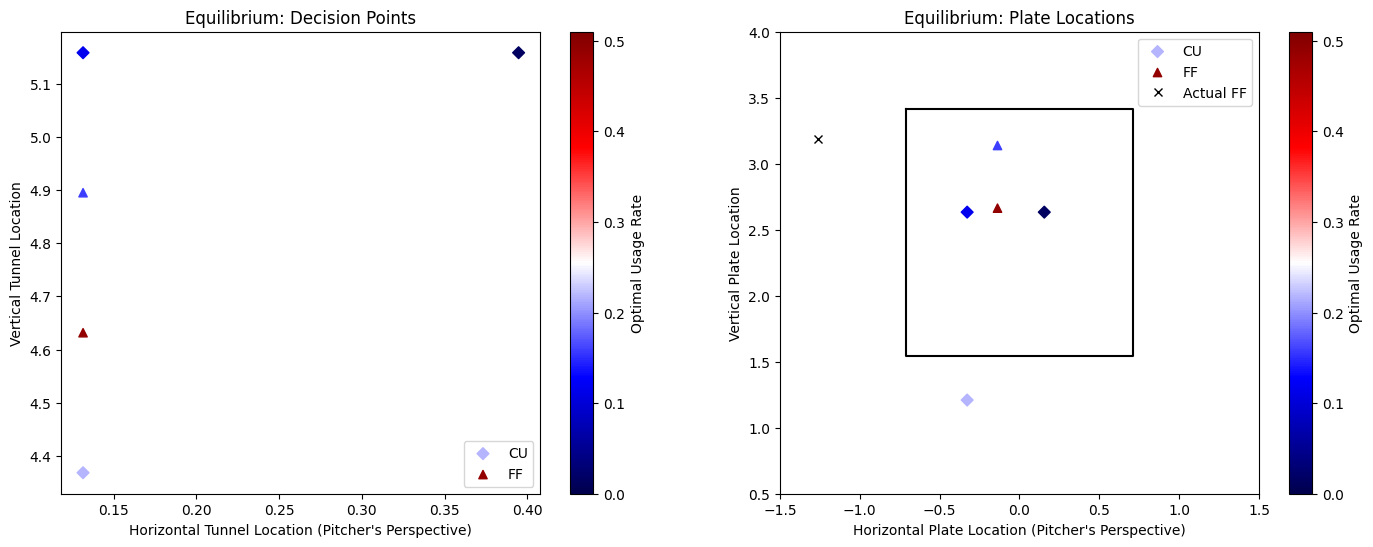

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']
axs[0].scatter(-1*cu.tunnel_x.values, cu.tunnel_z.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.51)
c=axs[0].scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.51)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[0].set_xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
axs[0].set_ylabel('Vertical Tunnel Location')
axs[0].legend()
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[0].set_title("Equilibrium: Decision Points")

axs[1].scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.51)
c=axs[1].scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.51)
#plot the standard strize zone as well
axs[1].plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Anderson threw
axs[1].plot([-1.26], [3.19], 'kx', label = "Actual FF")
axs[1].set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
axs[1].set_ylabel('Vertical Plate Location')
axs[1].set_xlim(-1.5,1.5)
axs[1].set_ylim(0.5,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[1].legend()
axs[1].set_title("Equilibrium: Plate Locations")
plt.show()

In [ ]:
#save the equilibrium A matrix and strategies for future reference
A1 = A.copy()
ps1 = ps.copy()
bs1 = bs.copy()
ps1 @ A1 @ bs1, util_pitcher

(0.010297736167657525, array([0.01029758]))

In [ ]:
#now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
np.random.seed(10)
int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
t = pitcher_df.tunnel_index.values[int_pitch_idx]
p = pitcher_df.pitch_type.values[int_pitch_idx]
int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

#get the probability of every other possible pitch given the execution error
mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
cs = int_pitch.command_skill.values[0]
no = mvnorm(mean, np.eye(2)*cs**2)
possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

np.random.seed(27)
act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
act_pitch = possible_pitches.iloc[[act_pitch_idx]]

#now sample a batter action from the actual tunnel
tunnel = act_pitch.tunnel_index.values[0]
batter_swing_prob = bs[tunnel*2]
np.random.seed(4001)
swing = np.random.binomial(n=1,p=batter_swing_prob)
if swing == 1:
  #sample from the swing outcomes
  p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
  p = p/p.sum()
  np.random.seed(7)
  outcome_index = np.random.choice(a = 7, p=p)
  outcome = [2,3,4,5,6,7,8][outcome_index]
else:
  #sample non swing outcomes
  p = act_pitch[['o0','o1']].values[0]
  p = p/p.sum()
  np.random.seed(70)
  outcome_index = np.random.choice(a=2, p = p)
  outcome = [0,1][outcome_index]

In [ ]:
int_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility
419,209,-0.131579,4.631579,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,0.137496,2.663551,0.112044,0.390443,0.264355,0.562248,1,1,605141,642,70,0.261113,0.738887,3.566808,2.962106,8.964581,1.952407,0,0,0.000631,0.39672,0.150666,0.307492,0.094448,0.025553,0.011275,0.000986,0.012228,0.144491,0.09192,0.015474,0.008294,0.001026,0.027777,0.013456,-0.042878


In [ ]:
act_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility,prob
417,208,-0.394737,4.631579,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,-0.345423,2.663551,-0.460161,0.390443,-0.627047,0.562248,1,1,605141,642,70,0.352976,0.647024,3.240298,2.634712,9.148873,1.876841,0,0,0.000999,0.417235,0.111043,0.308208,0.106079,0.029283,0.01294,0.001131,0.013081,0.162515,0.111592,0.017322,0.008027,0.000858,0.024716,0.000536,-0.042816,0.064483


In [ ]:
swing, outcome

(1, 2)

In [ ]:
#use the actual pitch and outcome to update the hidden state
x = torch.tensor(act_pitch[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR']].values, dtype = torch.float).to(device)
y = outcome
h += model.h_update(x, torch.tensor([y], dtype = torch.int).to(device))

In [ ]:
#update balls and strikes
balls = 0
strikes = 0
if outcome == 0:
  balls += 1
elif outcome == 1 or outcome == 2 or outcome == 3:
  strikes += 1

In [ ]:
#for this second equilibrium I'm doing the second pitch of the at bat
pitch_grid['balls'] = balls
pitch_grid['strikes'] = strikes
x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

#get the run values given a positioning for each of the positionings
pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

In [ ]:
#define the A matrices for each positioning
A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
#intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
    Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
A = A[1:,:]
Acb = Acb[1:, :]
Afb = Afb[1:,:]

In [ ]:
bs, ps, util_pitcher = get_strategies(A)
bsc, psc, util_cb = get_strategies(Acb)
bsf, psf, util_fb = get_strategies(Afb)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.5947e-02  1.5947e-02  2e+03  4e+01  8e+02  1e+00
 1:  3.5277e-01  2.4387e+00  1e+02  5e+00  1e+02  2e+00
 2:  3.7447e-01  4.9222e-01  1e+00  9e-02  2e+00  1e-01
 3:  8.6185e-02  9.1552e-02  1e-01  1e-02  2e-01  6e-03
 4:  8.7964e-03  1.0347e-02  4e-02  4e-03  9e-02  2e-03
 5:  9.2632e-03  1.0733e-02  4e-02  4e-03  9e-02  2e-03
 6:  5.1117e-03  6.1824e-03  4e-02  4e-03  7e-02  1e-03
 7:  2.3294e-03  2.9959e-03  3e-02  3e-03  5e-02  7e-04
 8: -1.3547e-04  1.3177e-05  1e-02  1e-03  2e-02  2e-04
 9: -2.9280e-03 -2.9084e-03  2e-03  2e-04  4e-03  3e-05
10: -3.1116e-03 -3.1051e-03  1e-03  1e-04  2e-03  9e-06
11: -3.1503e-03 -3.1445e-03  1e-03  1e-04  2e-03  8e-06
12: -3.1534e-03 -3.1500e-03  1e-03  1e-04  2e-03  6e-06
13: -3.2212e-03 -3.2204e-03  4e-04  4e-05  8e-04  2e-06
14: -3.2621e-03 -3.2620e-03  8e-05  7e-06  1e-04  3e-07
15: -3.2690e-03 -3.2690e-03  4e-06  4e-07  9e-06  1e-08
16: -3.2697e-03 -3.2697e-03  2e-07  2e-08  4e-07  

In [ ]:
util_pitcher, util_cb, util_fb

(array([0.00326975]), array([0.00336369]), array([0.00378743]))

In [ ]:
util_pitcher-util_cb, util_pitcher-util_fb

(array([-9.39393657e-05]), array([-0.00051768]))

the best utility is again the neutral matchup positioning utility

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': ps})
pitcher_df = pitcher_df.merge(pitcher_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
189,189,CU,0.289518,-0.131579,4.368421,0.327444,1.209669,-0.040080,0.023719
248,248,CU,0.029405,-0.394737,5.157895,-0.155475,2.633161,0.092012,-0.061858
249,249,CU,0.029722,-0.131579,5.157895,0.327444,2.633161,0.093013,-0.061836
609,209,FF,0.651333,-0.131579,4.631579,0.137496,2.663551,-0.000681,-0.061679


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: bs[ti*2:2*ti+2]})

batter_strats

{189: array([9.99999893e-01, 1.07229079e-07]),
 248: array([9.83120091e-07, 9.99999017e-01]),
 249: array([5.01747203e-07, 9.99999498e-01]),
 209: array([9.99999961e-01, 3.86711130e-08])}

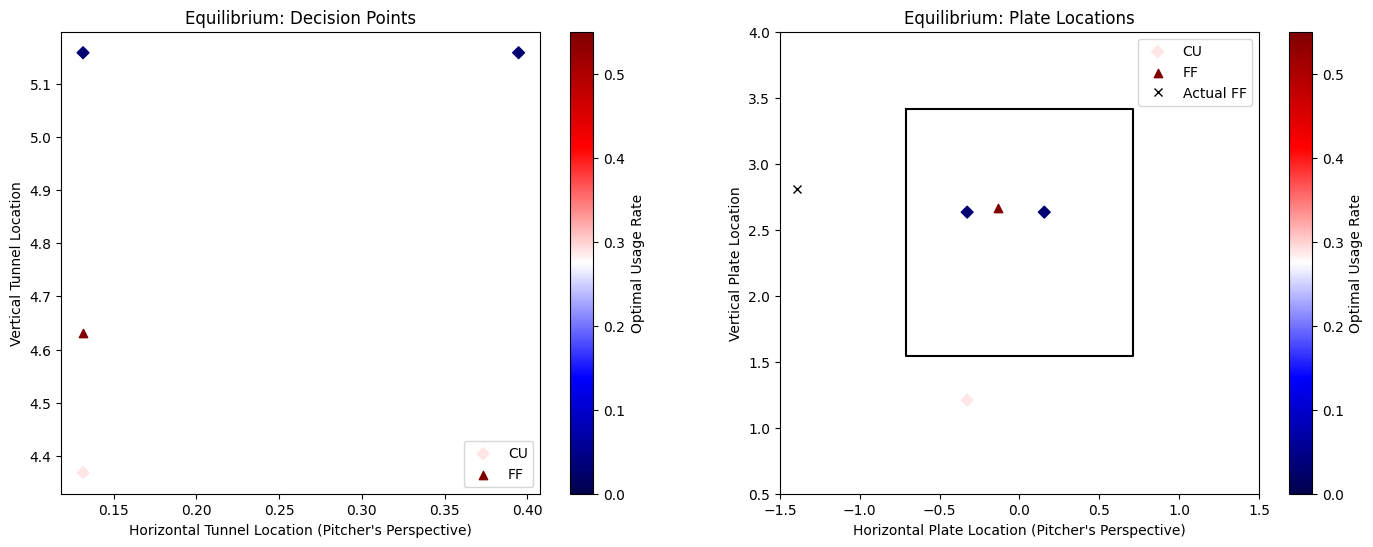

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']
axs[0].scatter(-1*cu.tunnel_x.values, cu.tunnel_z.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=axs[0].scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[0].set_xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
axs[0].set_ylabel('Vertical Tunnel Location')
axs[0].legend()
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[0].set_title("Equilibrium: Decision Points")

axs[1].scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=axs[1].scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
axs[1].plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Anderson threw
axs[1].plot([-1.39], [2.81], 'kx', label = "Actual FF")
axs[1].set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
axs[1].set_ylabel('Vertical Plate Location')
axs[1].set_xlim(-1.5,1.5)
axs[1].set_ylim(0.5,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[1].legend()
axs[1].set_title("Equilibrium: Plate Locations")
plt.show()

In [ ]:
#save the equilibrium A matrix and strategies for future reference
A2 = A.copy()
ps2 = ps.copy()
bs2 = bs.copy()
ps2 @ A2 @ bs2, util_pitcher

(0.0032698241909495662, array([0.00326975]))

In [ ]:
#now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
np.random.seed(120)
int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
t = pitcher_df.tunnel_index.values[int_pitch_idx]
p = pitcher_df.pitch_type.values[int_pitch_idx]
int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

#get the probability of every other possible pitch given the execution error
mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
cs = int_pitch.command_skill.values[0]
no = mvnorm(mean, np.eye(2)*cs**2)
possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

np.random.seed(2070)
act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
act_pitch = possible_pitches.iloc[[act_pitch_idx]]

#now sample a batter action from the actual tunnel
tunnel = act_pitch.tunnel_index.values[0]
batter_swing_prob = bs[tunnel*2]
np.random.seed(410)
swing = np.random.binomial(n=1,p=batter_swing_prob)
if swing == 1:
  #sample from the swing outcomes
  p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
  p = p/p.sum()
  np.random.seed(737)
  outcome_index = np.random.choice(a = 7, p=p)
  outcome = [2,3,4,5,6,7,8][outcome_index]
else:
  #sample non swing outcomes
  p = act_pitch[['o0','o1']].values[0]
  p = p/p.sum()
  np.random.seed(757)
  outcome_index = np.random.choice(a=2, p = p)
  outcome = [0,1][outcome_index]

In [ ]:
int_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility
419,209,-0.131579,4.631579,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,0.137496,2.663551,0.112044,0.390443,0.264355,0.562248,1,1,605141,642,70,0.261113,0.738887,3.566808,2.962106,8.964581,1.952407,0,1,0.000583,0.160947,0.251103,0.41449,0.111949,0.032751,0.013297,0.001195,0.013686,0.172877,0.109978,0.018514,0.009923,0.001227,0.033235,-0.000681,-0.061679


In [ ]:
act_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility,prob
413,206,-0.921053,4.631579,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,-1.311262,2.663551,-1.60457,0.390443,-2.409849,0.562248,1,1,605141,642,70,0.587839,0.412161,2.583136,1.920272,9.54571,1.730784,0,1,0.882635,0.001016,0.018451,0.069074,0.021935,0.005367,0.001142,0.000045,0.000335,0.028824,0.019933,0.007677,0.000963,0.00003,0.000221,-0.043422,0.026898,0.00743


In [ ]:
swing, outcome

(0, 0)

In [ ]:
#use the actual pitch and outcome to update the hidden state
x = torch.tensor(act_pitch[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR']].values, dtype = torch.float).to(device)
y = outcome
h += model.h_update(x, torch.tensor([y], dtype = torch.int).to(device))

In [ ]:
#update balls and strikes
if outcome == 0:
  balls += 1
elif outcome == 1 or outcome == 2 or outcome == 3:
  strikes += 1

In [ ]:
#simulate the third pitch
pitch_grid['balls'] = balls
pitch_grid['strikes'] = strikes
x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

#get the run values given a positioning for each of the positionings
pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

In [ ]:
#define the A matrices for each positioning
A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
#intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
    Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
A = A[1:,:]
Acb = Acb[1:, :]
Afb = Afb[1:,:]

In [ ]:
bs, ps, util_pitcher = get_strategies(A)
bsc, psc, util_cb = get_strategies(Acb)
bsf, psf, util_fb = get_strategies(Afb)

     pcost       dcost       gap    pres   dres   k/t
 0:  8.0144e-03  8.0144e-03  2e+03  4e+01  8e+02  1e+00
 1:  3.4576e-01  2.4677e+00  1e+02  5e+00  1e+02  2e+00
 2:  3.6772e-01  4.9094e-01  2e+00  1e-01  2e+00  1e-01
 3:  7.6109e-02  8.2204e-02  2e-01  1e-02  3e-01  6e-03
 4:  1.0045e-02  1.2658e-02  7e-02  7e-03  1e-01  3e-03
 5:  1.1442e-02  1.3942e-02  7e-02  7e-03  1e-01  3e-03
 6:  9.9734e-03  1.1963e-02  6e-02  6e-03  1e-01  2e-03
 7:  4.7946e-03  5.4082e-03  3e-02  3e-03  6e-02  7e-04
 8: -1.1558e-03 -9.8638e-04  1e-02  1e-03  2e-02  2e-04
 9: -2.5134e-03 -2.4470e-03  5e-03  5e-04  9e-03  8e-05
10: -3.3151e-03 -3.3018e-03  2e-03  2e-04  3e-03  2e-05
11: -3.4200e-03 -3.4128e-03  1e-03  1e-04  2e-03  1e-05
12: -3.4682e-03 -3.4638e-03  7e-04  7e-05  1e-03  6e-06
13: -3.5470e-03 -3.5465e-03  3e-04  3e-05  6e-04  1e-06
14: -3.5763e-03 -3.5763e-03  2e-05  2e-06  3e-05  6e-08
15: -3.5789e-03 -3.5789e-03  7e-07  7e-08  1e-06  3e-09
16: -3.5791e-03 -3.5791e-03  4e-08  4e-09  7e-08  

In [ ]:
util_pitcher, util_cb, util_fb

(array([0.00357909]), array([0.00373847]), array([0.00410045]))

In [ ]:
util_pitcher-util_cb, util_pitcher-util_fb

(array([-0.00015938]), array([-0.00052136]))

Still neutral positioning

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': ps})
pitcher_df = pitcher_df.merge(pitcher_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
189,189,CU,0.048956,-0.131579,4.368421,0.327444,1.209669,-0.049920,0.043246
209,209,CU,0.157794,-0.131579,4.631579,0.327444,1.684167,0.006995,-0.062952
229,229,CU,0.059670,-0.131579,4.894737,0.327444,2.158664,0.060248,-0.066784
248,248,CU,0.056892,-0.394737,5.157895,-0.155475,2.633161,0.071788,-0.066855
609,209,FF,0.676686,-0.131579,4.631579,0.137496,2.663551,-0.006086,-0.066417


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: bs[ti*2:2*ti+2]})

batter_strats

{189: array([9.99999982e-01, 1.77284595e-08]),
 209: array([9.99999993e-01, 7.12935164e-09]),
 229: array([9.99999990e-01, 1.04886883e-08]),
 248: array([0.24396532, 0.75603468])}

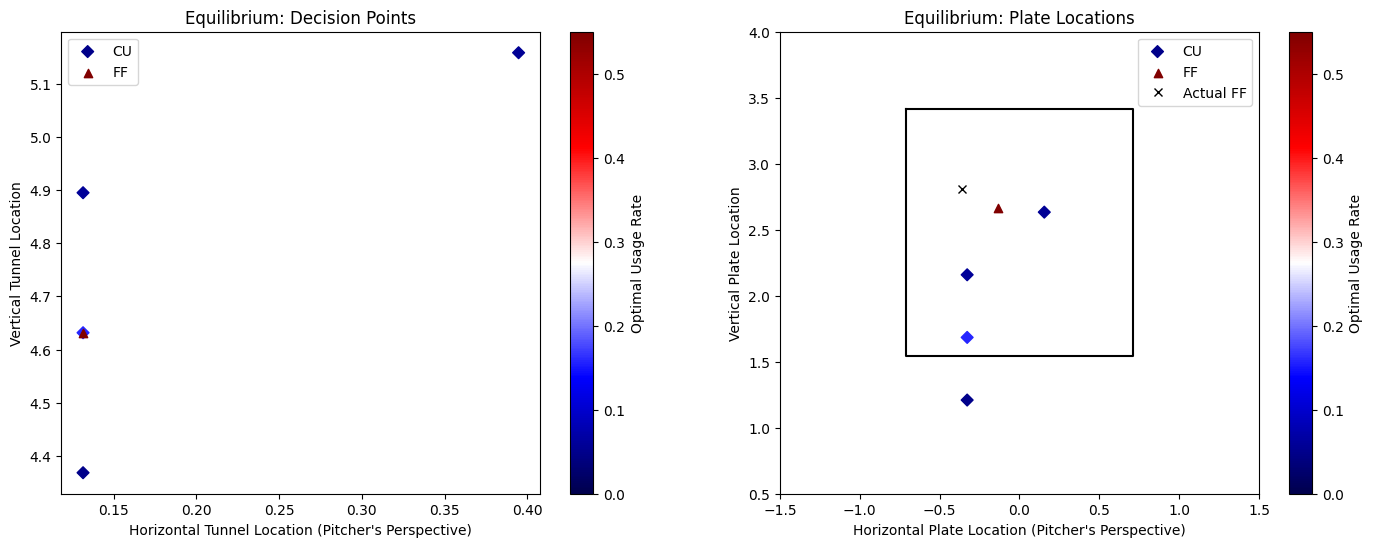

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']
axs[0].scatter(-1*cu.tunnel_x.values, cu.tunnel_z.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=axs[0].scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[0].set_xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
axs[0].set_ylabel('Vertical Tunnel Location')
axs[0].legend()
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[0].set_title("Equilibrium: Decision Points")

axs[1].scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=axs[1].scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
axs[1].plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Anderson threw
axs[1].plot([-.36], [2.81], 'kx', label = "Actual FF")
axs[1].set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
axs[1].set_ylabel('Vertical Plate Location')
axs[1].set_xlim(-1.5,1.5)
axs[1].set_ylim(0.5,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[1].legend()
axs[1].set_title("Equilibrium: Plate Locations")
plt.show()

In [ ]:
#save the equilibrium A matrix and strategies for future reference
A3 = A.copy()
ps3 = ps.copy()
bs3 = bs.copy()
ps3 @ A3 @ bs3, util_pitcher

(0.0035791019575861062, array([0.00357909]))

In [ ]:
#I want to save this pitch grid to compare to the next one for the paper's discussion on tipping
prev_pitch_grid = pitcher_pitch_grid.copy()

In [ ]:
#now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
np.random.seed(2011)
int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
t = pitcher_df.tunnel_index.values[int_pitch_idx]
p = pitcher_df.pitch_type.values[int_pitch_idx]
int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

#get the probability of every other possible pitch given the execution error
mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
cs = int_pitch.command_skill.values[0]
no = mvnorm(mean, np.eye(2)*cs**2)
possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

np.random.seed(999)
act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
act_pitch = possible_pitches.iloc[[act_pitch_idx]]

#now sample a batter action from the actual tunnel
tunnel = act_pitch.tunnel_index.values[0]
batter_swing_prob = bs[tunnel*2]
np.random.seed(4033)
swing = np.random.binomial(n=1,p=batter_swing_prob)
if swing == 1:
  #sample from the swing outcomes
  p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
  p = p/p.sum()
  np.random.seed(7777)
  outcome_index = np.random.choice(a = 7, p=p)
  outcome = [2,3,4,5,6,7,8][outcome_index]
else:
  #sample non swing outcomes
  p = act_pitch[['o0','o1']].values[0]
  p = p/p.sum()
  np.random.seed(7666)
  outcome_index = np.random.choice(a=2, p = p)
  outcome = [0,1][outcome_index]

In [ ]:
int_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility
419,209,-0.131579,4.631579,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,0.137496,2.663551,0.112044,0.390443,0.264355,0.562248,1,1,605141,642,70,0.261113,0.738887,3.566808,2.962106,8.964581,1.952407,1,1,0.000427,0.085346,0.26557,0.446448,0.128947,0.038183,0.015724,0.001381,0.017973,0.202208,0.128637,0.021656,0.011607,0.001436,0.038873,-0.006086,-0.066417


In [ ]:
act_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility,prob
461,230,0.131579,4.894737,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,0.620415,3.138048,0.684248,0.875685,1.155756,1.399286,1,1,605141,642,70,0.146064,0.853936,3.977872,3.51891,8.711271,1.983602,1,1,0.096062,0.257496,0.269878,0.281681,0.063935,0.017676,0.00705,0.000637,0.005586,0.094884,0.062784,0.012241,0.005415,0.000817,0.013626,-0.035915,-0.035211,0.049681


In [ ]:
swing, outcome

(1, 3)

In [ ]:
#use the actual pitch and outcome to update the hidden state
x = torch.tensor(act_pitch[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR']].values, dtype = torch.float).to(device)
y = outcome
h += model.h_update(x, torch.tensor([y], dtype = torch.int).to(device))

In [ ]:
#update balls and strikes
if outcome == 0:
  balls += 1
elif outcome == 1 or outcome == 2 or outcome == 3:
  strikes += 1

In [ ]:
#now simulate the next pitch
pitch_grid['balls'] = balls
pitch_grid['strikes'] = strikes
x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

#get the run values given a positioning for each of the positionings
pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

In [ ]:
#define the A matrices for each positioning
A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
#intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
    Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
A = A[1:,:]
Acb = Acb[1:, :]
Afb = Afb[1:,:]

In [ ]:
bs, ps, util_pitcher = get_strategies(A)
bsc, psc, util_cb = get_strategies(Acb)
bsf, psf, util_fb = get_strategies(Afb)

     pcost       dcost       gap    pres   dres   k/t
 0:  6.4356e-02  6.4356e-02  2e+03  4e+01  8e+02  1e+00
 1:  4.0281e-01  2.5131e+00  1e+02  5e+00  1e+02  2e+00
 2:  4.2412e-01  5.4901e-01  2e+00  1e-01  2e+00  1e-01
 3:  1.0759e-01  1.1434e-01  2e-01  2e-02  3e-01  7e-03
 4:  4.1051e-03  6.0698e-03  6e-02  6e-03  1e-01  2e-03
 5:  4.4428e-03  6.3119e-03  6e-02  6e-03  1e-01  2e-03
 6: -2.2058e-03 -1.0295e-03  5e-02  5e-03  9e-02  1e-03
 7: -1.5564e-03 -5.7466e-04  5e-02  4e-03  9e-02  1e-03
 8: -4.5290e-03 -3.9328e-03  3e-02  3e-03  6e-02  7e-04
 9: -1.0843e-02 -1.0824e-02  8e-03  8e-04  2e-02  4e-05
10: -1.2295e-02 -1.2290e-02  3e-03  3e-04  5e-03  1e-05
11: -1.2868e-02 -1.2869e-02  6e-04  6e-05  1e-03  1e-06
12: -1.2941e-02 -1.2941e-02  7e-05  7e-06  1e-04  1e-07
13: -1.2947e-02 -1.2947e-02  3e-05  3e-06  6e-05  5e-08
14: -1.2950e-02 -1.2950e-02  2e-05  2e-06  3e-05  1e-08
15: -1.2952e-02 -1.2952e-02  6e-07  5e-08  1e-06  5e-10
16: -1.2952e-02 -1.2952e-02  2e-08  2e-09  5e-08  

In [ ]:
util_pitcher, util_cb, util_fb

(array([0.01295213]), array([0.0127456]), array([0.01339445]))

In [ ]:
util_pitcher-util_cb, util_pitcher-util_fb

(array([0.00020653]), array([-0.00044232]))

Now curveball positioning is optimal

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': psc})
pitcher_df = pitcher_df.merge(cb_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
189,189,CU,0.280901,-0.131579,4.368421,0.327444,1.209669,-0.058720,0.035679
268,268,CU,0.064259,-0.394737,5.421053,-0.155475,3.107658,0.070618,-0.199705
269,269,CU,0.096391,-0.131579,5.421053,0.327444,3.107658,0.099713,-0.200195
569,169,FF,0.072634,-0.131579,4.105263,0.137496,1.714556,0.078090,-0.191187
570,170,FF,0.098579,0.131579,4.105263,0.620415,1.714556,0.015493,-0.153666
648,248,FF,0.099757,-0.394737,5.157895,-0.345423,3.612545,-0.041222,0.035370
649,249,FF,0.287475,-0.131579,5.157895,0.137496,3.612545,-0.040608,0.029953


In [ ]:
#which pitch does he throw more in this strategy
pitcher_df.groupby('pitch_type').agg(usage_rate = ('equilibrium_usage_rate', 'sum'))

,usage_rate
pitch_type,
CU,0.441551
FF,0.558446


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: bsc[ti*2:2*ti+2]})

batter_strats

{189: array([9.99999919e-01, 8.14626927e-08]),
 268: array([0.02864355, 0.97135645]),
 269: array([9.99998261e-01, 1.73853579e-06]),
 169: array([0.65368597, 0.34631403]),
 170: array([1.19784853e-07, 9.99999880e-01]),
 248: array([9.99999899e-01, 1.00574858e-07]),
 249: array([9.99999915e-01, 8.48626381e-08])}

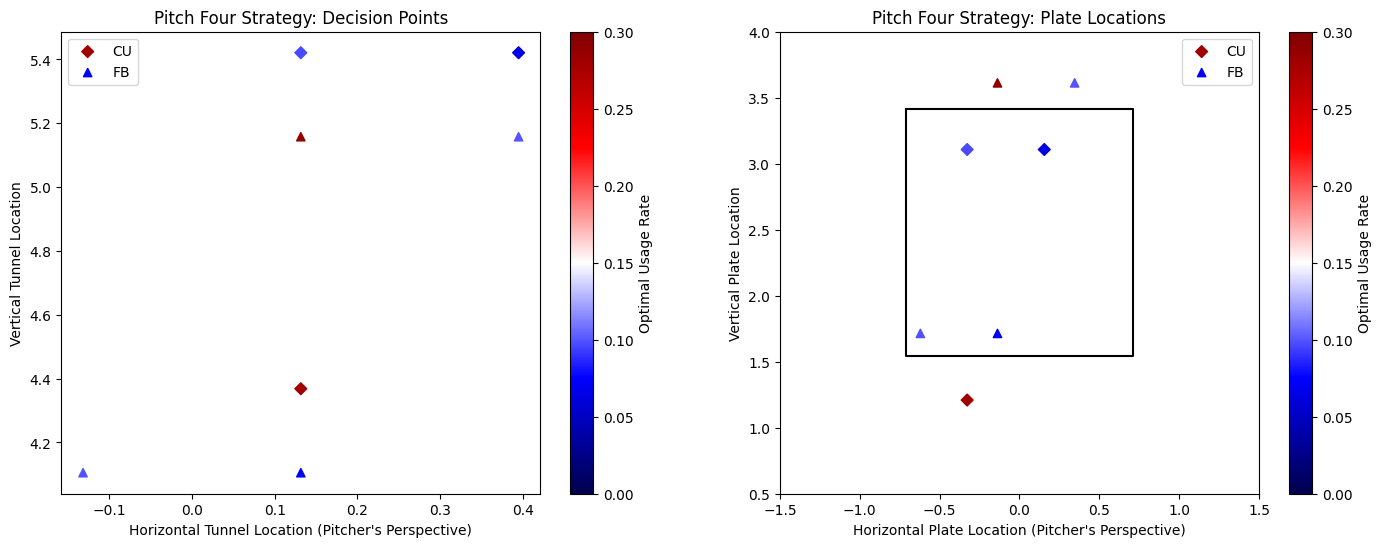

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']
axs[0].scatter(-1*cu.tunnel_x.values, cu.tunnel_z.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.3)
c=axs[0].scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FB', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.3)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[0].set_xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
axs[0].set_ylabel('Vertical Tunnel Location')
axs[0].legend()
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[0].set_title("Pitch Four Strategy: Decision Points")

axs[1].scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.3)
c=axs[1].scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FB', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.3)
#plot the standard strize zone as well
axs[1].plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[1].set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
axs[1].set_ylabel('Vertical Plate Location')
axs[1].set_xlim(-1.5,1.5)
axs[1].set_ylim(0.5,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[1].legend()
axs[1].set_title("Pitch Four Strategy: Plate Locations")
plt.show()

In [ ]:
#save the equilibrium A matrix and strategies for future reference
A4 = Acb.copy()
ps4 = psc.copy()
bs4 = bsc.copy()
ps4 @ A4 @ bs4, util_cb

(0.012745660841531413, array([0.0127456]))

In [ ]:
prev_pitch_grid.loc[prev_pitch_grid.tunnel_index == 209, ['tunnel_index', 'pitch_type', 'swing_utility', 'take_utility']]

,tunnel_index,pitch_type,swing_utility,take_utility
418,209,CU,0.006995,-0.062952
419,209,FF,-0.006086,-0.066417


In [ ]:
cb_pitch_grid.loc[cb_pitch_grid.tunnel_index == 209, ['tunnel_index', 'pitch_type', 'swing_utility', 'take_utility']]

,tunnel_index,pitch_type,swing_utility,take_utility
418,209,CU,0.040110,-0.182963
419,209,FF,0.059045,-0.203147


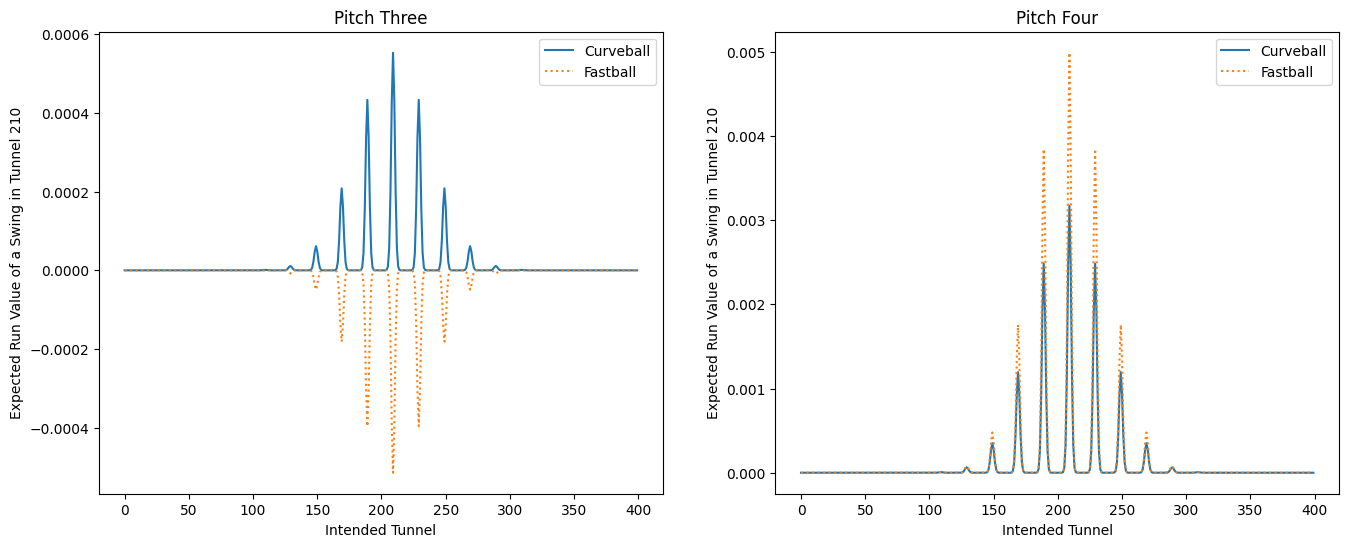

In [ ]:
plt.figure(figsize = (16,6))
ax1 = plt.subplot(121)
ax1.plot(A3[:400, 418], '-', label = 'Curveball')
ax1.plot(A3[400:, 418], ':', label = 'Fastball')
ax1.legend()
ax1.set_xlabel('Intended Tunnel')
ax1.set_title('Pitch Three')
ax1.set_ylabel('Expected Run Value of a Swing in Tunnel 210')

ax2 = plt.subplot(122)
ax2.plot(A4[:400, 418], '-', label = 'Curveball')
ax2.plot(A4[400:, 418], ':', label = 'Fastball')
ax2.legend()
ax2.set_xlabel('Intended Tunnel')
ax2.set_ylabel('Expected Run Value of a Swing in Tunnel 210')
ax2.set_title('Pitch Four')
plt.show()

I make the claim in the paper that the defense is now in a worst position to field batted fastballs, so check that that's true by comparing the swing utility on the fastballs in the sequencing strategy from the neutral positioning versus the curveball positioning. If the cost is positive, then we know they are in a worse position because the defense wants to minimize utility.

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': psc})
pitcher_df = pitcher_df.merge(cb_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])
pitcher_df['curveball_position_cost'] = (Acb - A)[:,::2].mean(axis = 1)
#the curveball position cost defined here is the change in expected run value of a swing at an intended pitch, regardless of where that pitch ends up, for each intended pitch

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility,curveball_position_cost
189,189,CU,0.280901,-0.131579,4.368421,0.327444,1.209669,-0.058720,0.035679,-3.905238e-06
268,268,CU,0.064259,-0.394737,5.421053,-0.155475,3.107658,0.070618,-0.199705,-3.437739e-06
269,269,CU,0.096391,-0.131579,5.421053,0.327444,3.107658,0.099713,-0.200195,-1.248783e-06
569,169,FF,0.072634,-0.131579,4.105263,0.137496,1.714556,0.078090,-0.191187,3.421421e-06
570,170,FF,0.098579,0.131579,4.105263,0.620415,1.714556,0.015493,-0.153666,5.793222e-06
648,248,FF,0.099757,-0.394737,5.157895,-0.345423,3.612545,-0.041222,0.035370,4.645231e-10
649,249,FF,0.287475,-0.131579,5.157895,0.137496,3.612545,-0.040608,0.029953,1.996895e-06


We see that all the fastballs in the sequencing equilibrium have positive curveball position costs, as expected. That means that they are in a worse position to field those balls.

In [ ]:
#now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
np.random.seed(601001)
int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
t = pitcher_df.tunnel_index.values[int_pitch_idx]
p = pitcher_df.pitch_type.values[int_pitch_idx]
int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

#get the probability of every other possible pitch given the execution error
mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
cs = int_pitch.command_skill.values[0]
no = mvnorm(mean, np.eye(2)*cs**2)
possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

np.random.seed(90210)
act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
act_pitch = possible_pitches.iloc[[act_pitch_idx]]

#now sample a batter action from the actual tunnel
tunnel = act_pitch.tunnel_index.values[0]
batter_swing_prob = bsc[tunnel*2]
np.random.seed(403309)
swing = np.random.binomial(n=1,p=batter_swing_prob)
if swing == 1:
  #sample from the swing outcomes
  p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
  p = p/p.sum()
  np.random.seed(77727)
  outcome_index = np.random.choice(a = 7, p=p)
  outcome = [2,3,4,5,6,7,8][outcome_index]
else:
  #sample non swing outcomes
  p = act_pitch[['o0','o1']].values[0]
  p = p/p.sum()
  np.random.seed(76626)
  outcome_index = np.random.choice(a=2, p = p)
  outcome = [0,1][outcome_index]

In [ ]:
int_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility
499,249,-0.131579,5.157895,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,0.137496,3.612545,0.112044,1.360927,0.264355,2.236323,1,1,605141,642,70,0.285849,0.714151,3.398036,2.873651,9.050777,1.858319,1,2,0.108648,0.007389,0.301382,0.424087,0.112281,0.028078,0.008991,0.000731,0.008413,0.158493,0.112648,0.015868,0.008084,0.001047,0.020847,-0.041654,0.029953


In [ ]:
act_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility,prob
457,228,-0.394737,4.894737,FF,95.784701,-0.460187,1.633228,-5.522239,19.598731,2293.619403,-0.688974,6.492444,0.657033,1.131513,-0.397399,1.329844,0.156789,1.140063,-0.347194,1.436663,-0.345423,3.138048,-0.460161,0.875685,-0.627047,1.399286,1,1,605141,642,70,0.387609,0.612391,3.134238,2.525595,9.217865,1.834519,1,2,0.001937,0.013569,0.155227,0.515328,0.218769,0.059672,0.01745,0.001266,0.016782,0.313939,0.223291,0.033131,0.014386,0.001357,0.041775,0.017767,-0.174522,0.049681


In [ ]:
swing, outcome

(1, 3)

That's a foul ball, so update the hidden state without updating balls and strikes since we already have two strikes, then simulate the next pitch.

In [ ]:
#use the actual pitch and outcome to update the hidden state
x = torch.tensor(act_pitch[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR']].values, dtype = torch.float).to(device)
y = outcome
h += model.h_update(x, torch.tensor([y], dtype = torch.int).to(device))

In [ ]:
#now simulate the next pitch
pitch_grid['balls'] = balls
pitch_grid['strikes'] = strikes
x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

#get the run values given a positioning for each of the positionings
pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

In [ ]:
#define the A matrices for each positioning
A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
#intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
    Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
A = A[1:,:]
Acb = Acb[1:, :]
Afb = Afb[1:,:]

In [ ]:
bs, ps, util_pitcher = get_strategies(A)
bsc, psc, util_cb = get_strategies(Acb)
bsf, psf, util_fb = get_strategies(Afb)

     pcost       dcost       gap    pres   dres   k/t
 0:  6.2772e-02  6.2772e-02  2e+03  4e+01  8e+02  1e+00
 1:  4.0155e-01  2.5160e+00  1e+02  5e+00  1e+02  2e+00
 2:  4.2290e-01  5.4837e-01  2e+00  1e-01  2e+00  1e-01
 3:  1.0628e-01  1.1273e-01  2e-01  2e-02  3e-01  7e-03
 4:  2.5057e-03  4.3657e-03  6e-02  6e-03  1e-01  2e-03
 5: -2.3957e-03 -1.0155e-03  5e-02  5e-03  1e-01  2e-03
 6: -1.0653e-02 -9.9788e-03  4e-02  4e-03  7e-02  8e-04
 7: -9.8210e-03 -9.2990e-03  3e-02  3e-03  6e-02  6e-04
 8: -1.2833e-02 -1.2589e-02  2e-02  2e-03  4e-02  3e-04
 9: -1.5498e-02 -1.5421e-02  8e-03  8e-04  1e-02  1e-04
10: -1.6213e-02 -1.6173e-02  5e-03  5e-04  1e-02  5e-05
11: -1.6872e-02 -1.6855e-02  2e-03  2e-04  5e-03  2e-05
12: -1.7231e-02 -1.7233e-02  1e-03  1e-04  3e-03  9e-07
13: -1.7274e-02 -1.7275e-02  7e-04  7e-05  1e-03  4e-07
14: -1.7303e-02 -1.7304e-02  3e-04  3e-05  6e-04  2e-07
15: -1.7317e-02 -1.7317e-02  7e-05  7e-06  1e-04  5e-08
16: -1.7320e-02 -1.7320e-02  4e-05  4e-06  8e-05  

In [ ]:
util_pitcher, util_cb, util_fb

(array([0.01732329]), array([0.01710828]), array([0.01792067]))

In [ ]:
util_pitcher-util_cb, util_pitcher-util_fb

(array([0.00021501]), array([-0.00059737]))

curveball positioning is again the best

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': psc})
pitcher_df = pitcher_df.merge(cb_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
169,169,CU,0.425305,-0.131579,4.105263,0.327444,0.735172,-0.153824,0.045975
189,189,CU,0.148991,-0.131579,4.368421,0.327444,1.209669,-0.056455,0.037741
288,288,CU,0.001316,-0.394737,5.684211,-0.155475,3.582155,0.000843,-0.024758
569,169,FF,0.191058,-0.131579,4.105263,0.137496,1.714556,0.093594,-0.188416
570,170,FF,0.220144,0.131579,4.105263,0.620415,1.714556,0.027857,-0.143108
649,249,FF,0.013183,-0.131579,5.157895,0.137496,3.612545,-0.020764,0.023597


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: bsc[ti*2:2*ti+2]})

batter_strats

{169: array([0.16217827, 0.83782173]),
 189: array([9.99999975e-01, 2.49241389e-08]),
 288: array([1.01265365e-06, 9.99998987e-01]),
 170: array([3.91601583e-08, 9.99999961e-01]),
 249: array([9.99999867e-01, 1.33131001e-07])}

There's tunneling happening here between fastball and curveball, as well as mixing. The fastball has bad take utility, but curveball has bad swing utility in tunnel 169, and the batter mixes between swinging and taking in that tunnel, but mostly taking. That makes sense because the pitcher throws the curveball, which he should take, much more than the fastball through that tunnel.

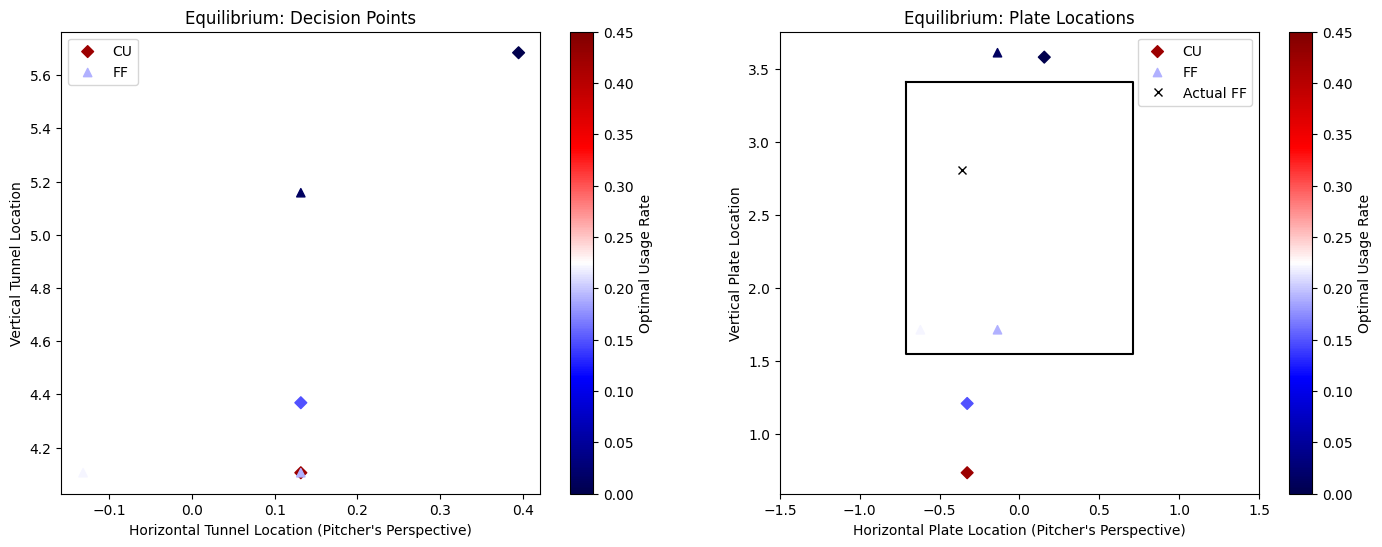

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']
axs[0].scatter(-1*cu.tunnel_x.values, cu.tunnel_z.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.45)
c=axs[0].scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.45)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[0].set_xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
axs[0].set_ylabel('Vertical Tunnel Location')
axs[0].legend()
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[0].set_title("Equilibrium: Decision Points")

axs[1].scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.45)
c=axs[1].scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.45)
#plot the standard strize zone as well
axs[1].plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Anderson threw
axs[1].plot([-.36], [2.81], 'kx', label = "Actual FF")
axs[1].set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
axs[1].set_ylabel('Vertical Plate Location')
axs[1].set_xlim(-1.5,1.5)
#axs[1].set_ylim(0.5,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[1].legend()
axs[1].set_title("Equilibrium: Plate Locations")
plt.show()

In [ ]:
#save the equilibrium A matrix and strategies for future reference
A5 = Acb.copy()
ps5 = psc.copy()
bs5 = bsc.copy()
ps5 @ A5 @ bs5, util_cb

(0.017108329839021358, array([0.01710828]))

In [ ]:
#now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
np.random.seed(71)
int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
t = pitcher_df.tunnel_index.values[int_pitch_idx]
p = pitcher_df.pitch_type.values[int_pitch_idx]
int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

#get the probability of every other possible pitch given the execution error
mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
cs = int_pitch.command_skill.values[0]
no = mvnorm(mean, np.eye(2)*cs**2)
possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

np.random.seed(906)
act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
act_pitch = possible_pitches.iloc[[act_pitch_idx]]

#now sample a batter action from the actual tunnel
tunnel = act_pitch.tunnel_index.values[0]
batter_swing_prob = bsc[tunnel*2]
np.random.seed(49)
swing = np.random.binomial(n=1,p=batter_swing_prob)
if swing == 1:
  #sample from the swing outcomes
  p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
  p = p/p.sum()
  np.random.seed(77777)
  outcome_index = np.random.choice(a = 7, p=p)
  outcome = [2,3,4,5,6,7,8][outcome_index]
else:
  #sample non swing outcomes
  p = act_pitch[['o0','o1']].values[0]
  p = p/p.sum()
  np.random.seed(7267)
  outcome_index = np.random.choice(a=2, p = p)
  outcome = [0,1][outcome_index]

In [ ]:
int_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility
338,169,-0.131579,4.105263,CU,83.469122,0.138045,-0.091756,1.656544,-1.101076,2066.628895,-0.613484,6.465751,0.679269,-0.887386,0.284783,-0.979588,-0.52203,-0.911307,0.324187,-1.04568,0.327444,0.735172,0.337111,-1.581603,0.614973,-2.839512,1,1,605141,642,70,0.631368,0.368632,2.94403,1.77201,9.526837,1.949207,1,2,0.512128,0.00005,0.375771,0.067618,0.034748,0.00882,0.000736,0.000029,0.000101,0.044433,0.030019,0.012959,0.001272,0.000049,0.000134,-0.153232,0.045975


In [ ]:
act_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility,prob
342,171,0.394737,4.105263,CU,83.469122,0.138045,-0.091756,1.656544,-1.101076,2066.628895,-0.613484,6.465751,0.679269,-0.887386,0.284783,-0.979588,-0.52203,-0.911307,0.324187,-1.04568,1.293283,0.735172,1.48152,-1.581603,2.397775,-2.839512,1,1,605141,642,70,0.343127,0.656873,3.895075,2.655933,9.069438,2.119435,1,2,0.853739,0.000003,0.139098,0.004394,0.002115,0.000631,0.000019,6.017714e-07,0.000001,0.002766,0.002047,0.000705,0.000014,7.409558e-07,0.0,-0.195932,0.045999,0.028763


In [ ]:
swing, outcome

(0, 0)

In [ ]:
#ball two, so we continue
#use the actual pitch and outcome to update the hidden state
x = torch.tensor(act_pitch[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR']].values, dtype = torch.float).to(device)
y = outcome
h += model.h_update(x, torch.tensor([y], dtype = torch.int).to(device))

In [ ]:
#update balls and strikes
if outcome == 0:
  balls += 1
elif outcome == 1 or outcome == 2 or outcome == 3:
  strikes += 1

In [ ]:
balls, strikes

(2, 2)

In [ ]:
#now simulate the next pitch
pitch_grid['balls'] = balls
pitch_grid['strikes'] = strikes
x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
preds = nn.functional.softmax(model.input_embedding(x, h.repeat(x.size(0),1)), dim = 1)
pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

#get the run values given a positioning for each of the positionings
pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

In [ ]:
#define the A matrices for each positioning
A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
Acb = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
Afb = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
#intended_tunnels = pitch_grid.loc[(pitch_grid.plate_x_ft >= -1.5) & (pitch_grid.plate_x_ft <= 1.5) & (pitch_grid.plate_z_ft >=1) & (pitch_grid.plate_z_ft <= 4), 'tunnel_index'].unique()
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    Acb = np.vstack((Acb, get_A_for_tunnel(cb_pitch_grid, t, p)))
    Afb = np.vstack((Afb, get_A_for_tunnel(fb_pitch_grid, t, p)))
A = A[1:,:]
Acb = Acb[1:, :]
Afb = Afb[1:,:]

In [ ]:
bs, ps, util_pitcher = get_strategies(A)
bsc, psc, util_cb = get_strategies(Acb)
bsf, psf, util_fb = get_strategies(Afb)

     pcost       dcost       gap    pres   dres   k/t
 0:  5.9232e-02  5.9232e-02  2e+03  4e+01  8e+02  1e+00
 1:  3.9769e-01  2.5125e+00  1e+02  5e+00  1e+02  2e+00
 2:  4.1847e-01  5.4610e-01  2e+00  1e-01  2e+00  1e-01
 3:  7.6587e-02  8.5161e-02  2e-01  2e-02  4e-01  9e-03
 4: -2.8198e-03  1.2821e-03  1e-01  1e-02  2e-01  4e-03
 5:  3.2690e-04  4.1780e-03  1e-01  1e-02  2e-01  4e-03
 6: -1.4963e-03  5.4772e-04  8e-02  8e-03  2e-01  2e-03
 7: -1.6913e-02 -1.6447e-02  3e-02  2e-03  5e-02  5e-04
 8: -1.9890e-02 -1.9723e-02  1e-02  1e-03  2e-02  2e-04
 9: -2.0880e-02 -2.0798e-02  6e-03  6e-04  1e-02  1e-04
10: -2.1074e-02 -2.1016e-02  6e-03  5e-04  1e-02  7e-05
11: -2.1642e-02 -2.1625e-02  2e-03  2e-04  3e-03  2e-05
12: -2.1858e-02 -2.1856e-02  5e-04  5e-05  9e-04  4e-06
13: -2.1915e-02 -2.1915e-02  3e-05  2e-06  5e-05  2e-07
14: -2.1919e-02 -2.1919e-02  1e-06  9e-08  2e-06  6e-09
15: -2.1920e-02 -2.1920e-02  4e-08  4e-09  8e-08  3e-10
Optimal solution found.
Status: optimal
     pcost

In [ ]:
util_pitcher, util_cb, util_fb

(array([0.02191979]), array([0.0217482]), array([0.02293932]))

In [ ]:
util_pitcher-util_cb, util_pitcher-util_fb

(array([0.00017159]), array([-0.00101954]))

once again, curveball positioning is optimal

In [ ]:
pitches_list = []
ti = []
for p in pitcher_pitch_grid.pitch_type.unique():
  for t in range(pitcher_pitch_grid.tunnel_index.max() + 1):
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': psc})
pitcher_df = pitcher_df.merge(cb_pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
188,188,CU,0.018873,-0.394737,4.368421,-0.155475,1.209669,-0.067631,0.079924
189,189,CU,0.526831,-0.131579,4.368421,0.327444,1.209669,-0.096729,0.080303
589,189,FF,0.443700,-0.131579,4.368421,0.137496,2.189054,0.099939,-0.249214
649,249,FF,0.010595,-0.131579,5.157895,0.137496,3.612545,-0.033382,0.070415


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: bsc[ti*2:2*ti+2]})

batter_strats

{188: array([9.99999993e-01, 7.48384953e-09]),
 189: array([9.99999993e-01, 6.87961268e-09]),
 249: array([9.99999973e-01, 2.74535386e-08])}

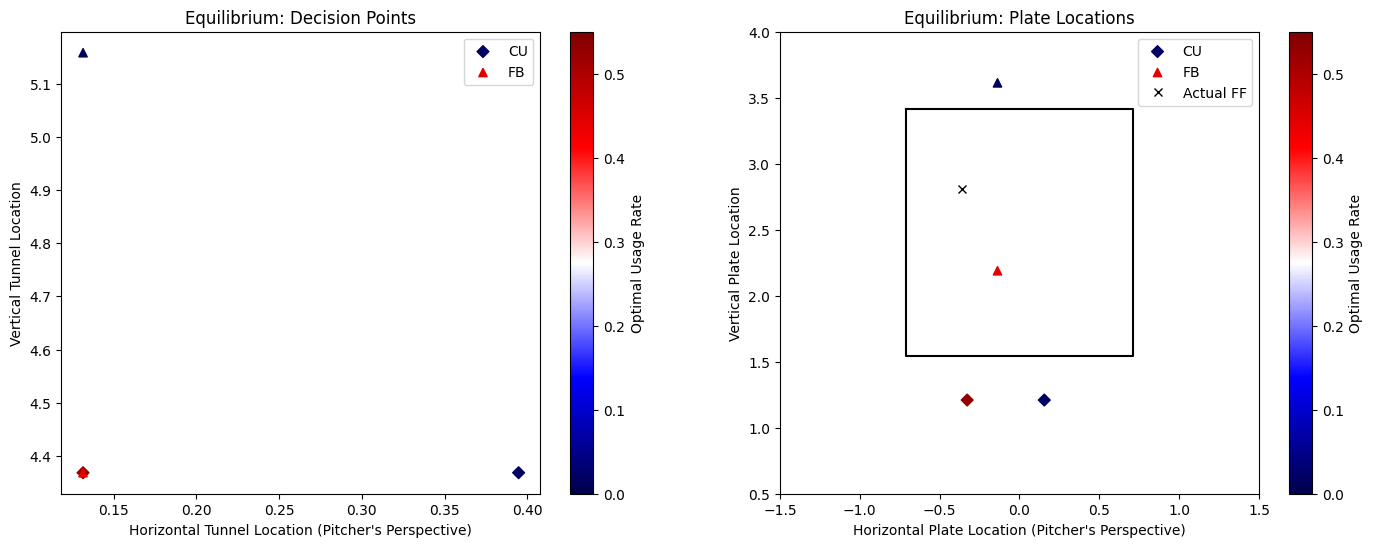

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']
axs[0].scatter(-1*cu.tunnel_x.values, cu.tunnel_z.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=axs[0].scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FB', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
axs[0].set_xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
axs[0].set_ylabel('Vertical Tunnel Location')
axs[0].legend()
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[0].set_title("Equilibrium: Decision Points")

axs[1].scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=axs[1].scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FB', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
axs[1].plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Anderson threw
axs[1].plot([-.36], [2.81], 'kx', label = "Actual FF")
axs[1].set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
axs[1].set_ylabel('Vertical Plate Location')
axs[1].set_xlim(-1.5,1.5)
axs[1].set_ylim(0.5,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
axs[1].legend()
axs[1].set_title("Equilibrium: Plate Locations")
plt.show()

Now we have some tunneling going on. The two most used pitches are fastball and curveball in the same tunnel with slightly higher probability for the curveball. Betts is supposed to swing 100% of the time in that tunnel even though it is bad for him to swing at the curveball because not swinging at the fastball is even worse.

In [ ]:
#save the equilibrium A matrix and strategies for future reference
A6 = Acb.copy()
ps6 = psc.copy()
bs6 = bsc.copy()
ps6 @ A6 @ bs6, util_cb

(0.0217482134198265, array([0.0217482]))

In [ ]:
#now let's randomly sample a pitch using the pitcher's strategy distribution and the execution error.
np.random.seed(74)
int_pitch_idx = np.random.choice(a = pitcher_df.shape[0], p=pitcher_df.equilibrium_usage_rate.values/pitcher_df.equilibrium_usage_rate.values.sum())
t = pitcher_df.tunnel_index.values[int_pitch_idx]
p = pitcher_df.pitch_type.values[int_pitch_idx]
int_pitch = pitcher_pitch_grid.loc[(pitcher_pitch_grid.tunnel_index == t) & (pitcher_pitch_grid.pitch_type == p)]

#get the probability of every other possible pitch given the execution error
mean = int_pitch[['plate_x_ft', 'plate_z_ft']].values[0]
cs = int_pitch.command_skill.values[0]
no = mvnorm(mean, np.eye(2)*cs**2)
possible_pitches = pitcher_pitch_grid.loc[pitcher_pitch_grid.pitch_type == int_pitch.pitch_type.values[0]]
possible_pitches['prob'] = no.pdf(possible_pitches[['plate_x_ft', 'plate_z_ft']].values)
possible_pitches.prob = possible_pitches.prob.values/possible_pitches.prob.values.sum()

np.random.seed(96)
act_pitch_idx = np.random.choice(a = possible_pitches.shape[0], p = possible_pitches.prob.values)
act_pitch = possible_pitches.iloc[[act_pitch_idx]]

#now sample a batter action from the actual tunnel
tunnel = act_pitch.tunnel_index.values[0]
batter_swing_prob = bsc[tunnel*2]
np.random.seed(50)
swing = np.random.binomial(n=1,p=batter_swing_prob)
if swing == 1:
  #sample from the swing outcomes
  p = act_pitch[['o2', 'o3', 'xout', 'x1b', 'x2b', 'x3b', 'xhr']].values[0]
  p = p/p.sum()
  np.random.seed(78)
  outcome_index = np.random.choice(a = 7, p=p)
  outcome = [2,3,4,5,6,7,8][outcome_index]
else:
  #sample non swing outcomes
  p = act_pitch[['o0','o1']].values[0]
  p = p/p.sum()
  np.random.seed(7268)
  outcome_index = np.random.choice(a=2, p = p)
  outcome = [0,1][outcome_index]

In [ ]:
int_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility
378,189,-0.131579,4.368421,CU,83.469122,0.138045,-0.091756,1.656544,-1.101076,2066.628895,-0.613484,6.465751,0.679269,-0.887386,0.284783,-0.979588,-0.52203,-0.911307,0.324187,-1.04568,0.327444,1.209669,0.337111,-1.096361,0.614973,-2.002474,1,1,605141,642,70,0.622486,0.377514,2.94944,1.804767,9.517732,1.933537,2,2,0.20648,0.010996,0.334703,0.227568,0.162205,0.046623,0.008578,0.000643,0.002203,0.220252,0.145265,0.059376,0.011082,0.000565,0.003964,-0.094547,0.080303


In [ ]:
act_pitch

,tunnel_index,tunnel_x,tunnel_z,pitch_type,release_speed,pfx_x,pfx_z,mx,mz,release_spin_rate,release_pos_x,release_pos_z,command_skill,release_speed_z,mx_z,mz_z,release_spin_rate_z,release_speed_bip_z,mx_bip_z,mz_bip_z,plate_x_ft,plate_z_ft,plate_x_z,plate_z_z,plate_x_bip_z,plate_z_bip_z,pit_handR,bat_handR,batter,bip_batter_index,batter_index,w1,w2,a1,a2,b1,b2,balls,strikes,o0,o1,o2,o3,o4,o5,o6,o7,o8,xbip,xout,x1b,x2b,x3b,xhr,swing_utility,take_utility,prob
336,168,-0.394737,4.105263,CU,83.469122,0.138045,-0.091756,1.656544,-1.101076,2066.628895,-0.613484,6.465751,0.679269,-0.887386,0.284783,-0.979588,-0.52203,-0.911307,0.324187,-1.04568,-0.155475,0.735172,-0.235094,-1.581603,-0.276429,-2.839512,1,1,605141,642,70,0.6822,0.3178,2.575154,1.585927,9.644385,1.854678,2,2,0.429601,0.000077,0.409935,0.109667,0.039093,0.00988,0.001446,0.000053,0.000248,0.05072,0.033111,0.014075,0.002849,0.000095,0.00059,-0.17688,0.097937,0.048098


In [ ]:
swing, outcome

(1, 2)

That is swinging strike three at a curveball below the zone. Very cool. 6 pitch at bat that ended with count 2-3 and had one foul ball on strike 2, hence why the count ended with five pitches

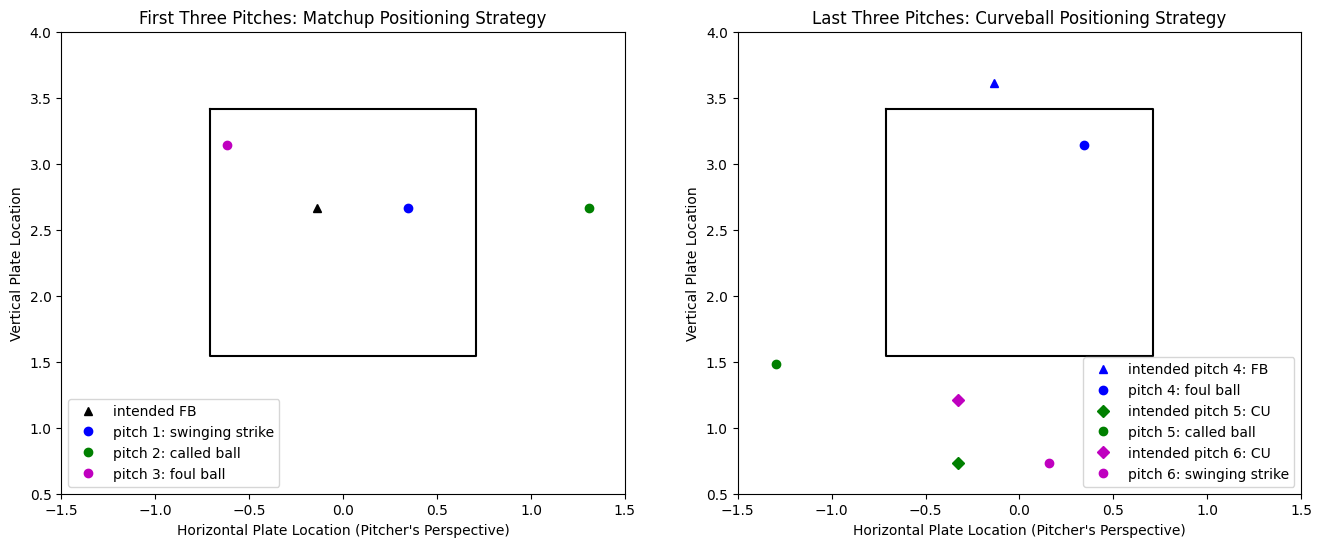

In [ ]:
#plot all the intended targets and actual pitches for each pitch in the at bat for the paper
plt.figure(figsize = (16,6))
ax1 = plt.subplot(121)
ax1.plot([-.137496], [2.663551], 'k^', label = 'intended FB')
ax1.plot([0.345423], [2.663551], 'bo', label = 'pitch 1: swinging strike')
ax1.plot([1.3111262], [2.663551], 'go', label = 'pitch 2: called ball')
ax1.plot([-0.620415], [3.138048], 'mo', label = 'pitch 3: foul ball')
ax1.set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
ax1.set_ylabel("Vertical Plate Location")
ax1.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
ax1.legend()
ax1.set_xlim((-1.5,1.5))
ax1.set_ylim((0.5,4))
ax1.set_title("First Three Pitches: Matchup Positioning Strategy")

ax2 = plt.subplot(122)
ax2.plot([-0.137496], [3.612545], 'b^', label = 'intended pitch 4: FB')
ax2.plot([0.345423], [3.138048], 'bo', label = 'pitch 4: foul ball')
ax2.plot([-0.327444], [0.735172], 'gD', label = 'intended pitch 5: CU')
ax2.plot([-1.293283], [1.48152], 'go', label = 'pitch 5: called ball')
ax2.plot([-0.327444], [1.209669], 'mD', label = 'intended pitch 6: CU')
ax2.plot([0.155475], [0.735172], 'mo', label = 'pitch 6: swinging strike')
ax2.legend()
ax2.set_xlabel("Horizontal Plate Location (Pitcher's Perspective)")
ax2.set_ylabel("Vertical Plate Location")
ax2.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
ax2.set_xlim((-1.5,1.5))
ax2.set_ylim((0.5,4))
ax2.set_title('Last Three Pitches: Curveball Positioning Strategy')
plt.show()